# **Atividade 2**

Nesta etapa, o desafio é transformar descrições textuais de assaltos em um grafo de cidades baseado em similaridade semântica, e então usar cadeias de Markov para prever onde é mais provável que ocorram novos assaltos.
-	Gerar embeddings das descrições de assaltos (com sentence-transformers).
-	Calcular similaridade de cosseno entre os embeddings de cada cidade.
-	Conectar no grafo as cidades cuja similaridade ultrapassar um limiar (pra garantir um grafo conexo).
-	Montar a matriz de adjacência a partir desses graus de vértices.
-	Converter essa matriz em uma matriz de transição estocástica para a cadeia de Markov.
-	Aplicar um método (distribuição estacionária ou simulação de passos) para obter a probabilidade estacionária de cada cidade — ou seja, a chance relativa de futuros assaltos em função da estrutura do grafo.

Esse resumo orienta todo o notebook: primeiro construo o grafo semântico, depois uso Markov para chegar às previsões de risco por cidade.

In [1]:
#Nessa celula e nas próximas eu só importo bibliotecas e inicializo os dados
try:
  from sentence_transformers import SentenceTransformer, util
except:
    print("sentence_transformers não está instalado. Instalando...")
    %pip install -U sentence-transformers
    from sentence_transformers import SentenceTransformer, util
try:
  import torch
except:
    print("torch não está instalado. Instalando...")
    %pip install transformers torch
    import torch

In [2]:
!python -m spacy download pt_core_news_sm

import spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 52.8 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


Importo as bibliotecas principais (pandas, numpy, nltk, networkx, matplotlib etc.), carrego o modelo spaCy, baixo recursos do NLTK e, por fim, carrego o conjunto de dados de ocorrências.


In [3]:
# importo bibliotecas essenciais para manipulação de dados, regex, NLP e grafos
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# tento importar seaborn para visualização; se não estiver instalado, instalo na hora
try:
    import seaborn as sns
except ImportError:
    print("seaborn não está instalado. Instalando...")
    %pip install seaborn
    import seaborn as sns

# baixo recursos do NLTK (stopwords e puntuação) silenciosamente
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    print("NLTK resources 'stopwords' e 'punkt' verificadas/baixadas.")
except Exception as e:
    print(f"Erro ao baixar recursos NLTK: {e}")

# carrego o modelo spaCy em português sem parser e ner pra acelerar tokenização
try:
    nlp_pt = spacy.load("pt_core_news_sm", disable=["parser", "ner"])
    nlp_pt.max_length = 1_500_000
    print("Modelo 'pt_core_news_sm' carregado com parser e ner desabilitados.")
except OSError:
    raise OSError("Modelo 'pt_core_news_sm' não encontrado. Execute: python -m spacy download pt_core_news_sm")

# se o arquivo de ocorrências não estiver no diretório, baixo do Google Drive
if not os.path.exists('assaltos.xlsx'):
    get_ipython().system('gdown 1N9EOJWsbAAiGHaUuEPDHybX9Y1YG976h -O assaltos.xlsx')

# leio a planilha com descrições de assaltos para o DataFrame
df_ocorrencias = pd.read_excel('assaltos.xlsx')
print("\nDataFrame Original Carregado:")
df_ocorrencias

NLTK resources 'stopwords' e 'punkt' verificadas/baixadas.
Modelo 'pt_core_news_sm' carregado com parser e ner desabilitados.

DataFrame Original Carregado:


descricao  \
0      Moradores do Ipiranga, na Zona Sul, sofrem com...   
1      Câmera registra assalto na zona leste de SP: “...   
2      Cidade de São Paulo tem queda de roubos e aume...   
3      Delegacia de Pinheiros registra o maior número...   
4      Assalto a comércio termina com ladrão morto e ...   
...                                                  ...   
15631  Condenado por estupro é preso em Itaperuna - N...   
15632  Polícia prende 'Guerreiro', chefe do tráfico d...   
15633  Prefeito de Itaperuna lidera intenções de voto...   
15634  Atlas da Violência 2024: Rio tem 15 das 100 ci...   
15635  Vídeo mostra assalto na frente de igreja em Gu...   

                   municipio  
0      São Paulo, SP, BRAZIL  
1      São Paulo, SP, BRAZIL  
2      São Paulo, SP, BRAZIL  
3      São Paulo, SP, BRAZIL  
4      São Paulo, SP, BRAZIL  
...                      ...  
15631  Itaperuna, RJ, BRAZIL  
15632  Itaperuna, RJ, BRAZIL  
15633  Itaperuna, RJ, BRAZIL  
15634  Itaperuna, RJ, BRAZIL  
15635  Itaperuna, RJ, BRAZIL  

[15636 rows x 2 columns]

# **Limpeza de Texto e Análise Exploratória das Ocorrências**

Antes de criar os embeddings, eu precisei extrair cidade e estado do campo municipio e limpar as descrições para manter só o texto relevante:

1.	Extração de cidade e estado

-	A função extrai_cidade_estado separa a string "Cidade, UF" em duas colunas, para eu ter depois a granularidade por estado e município no meu DataFrame.

2.	Limpeza das descrições

-	Removo URLs e uma série de “ruídos” comuns em notícias (nome de portais, menções a vídeos/fotos, redes sociais etc.) com um regex (pattern_deny).
-	Depois uso outro regex para ficar só com letras, números e espaços.
-	Por fim, rodo o texto no spaCy em português e filtro tokens para tirar stopwords, dígitos e pedaços muito curtos.
-	O resultado vai para a coluna descricao_limpa.

3.	Verificação rápida

-	Imprimo alguns exemplos lado a lado (descricao vs. descricao_limpa) para conferir se a limpeza fez sentido.

4.	Análise inicial

-	Com seaborn, mostro um gráfico de barras do número de ocorrências por estado — isso me dá uma visão de onde estão concentrados os dados.
-	Em seguida, ploto o Top 100 cidades por quantidade de assaltos, para entender quais municípios têm mais casos e podem influenciar o limiar de similaridade que vou usar no grafo.


Esses passos garantem que o texto de cada ocorrência está pronto para virar embedding de qualidade e que eu já sei como os dados estão distribuídos geograficamente antes de modelar o grafo semântico.

In [4]:
# separa “Cidade, UF” em duas colunas, pra usar depois na análise por estado/município
def extrai_cidade_estado(texto_mun):
    partes = [p.strip() for p in texto_mun.split(',')]
    cidade = partes[0]
    uf = partes[1]
    return cidade, uf

# aplica a função e já cria as colunas 'cidade' e 'estado' no DataFrame
df_ocorrencias[['cidade', 'estado']] = df_ocorrencias['municipio'].apply(
    lambda x: pd.Series(extrai_cidade_estado(x))
)

# conjunto de stopwords em português pra filtrar tokens pós-tokenização
stop_words_pt = set(stopwords.words("portuguese"))

# lista de padrões que representem ruído (nomes de portais, redes sociais, comandos tipo “leia”, URLs)
deny_patterns = [
    r"cnn", r"g1", r"globo", r"record", r"sbt", r"band", r"uol", r"r7",
    r"terra", r"youtube", r"facebook", r"instagram", r"twitter", r"tiktok",
    r"whatsapp", r"telegram", r"portal\s+\w+", r"site\s+\w+", r"\bveja\b",
    r"\bleia\b", r"\bfoto(?:s)?\b", r"\bvídeo(?:s)?\b", r"\.com(?:\.br)?",
    r"\.net(?:\.br)?", r"são paulo", r"brasil", r" sp", r"zona oeste",
    r"zona leste", r"zona norte", r"zona sul", "news", r"diário", r"notícias",
    r"jornal", r"folha", r"bahia", r"gazeta", r"gzh", r"caxias", r"paraná"
] # Tem muitas outras que eu gostaria de tirar, mas essas são as mais comuns e as que tive paciência de fazer na mão
pattern_deny = re.compile(r"(" + r"|".join(deny_patterns) + r")", flags=re.IGNORECASE)

# função que limpa cada descrição, mantendo só o texto relevante
def limpar_preservando_texto(texto: str) -> str:
    if not isinstance(texto, str):
        return ""

    # tira URLs e substitui por espaço
    sem_urls = re.sub(r"https?://\S+|www\.\S+", " ", texto)
    # remove trechos que combinam com o deny_patterns
    sem_ruido = pattern_deny.sub(" ", sem_urls)
    # deixa só letras, números e espaços
    apenas_texto = re.sub(r"[^A-Za-zÀ-ú0-9\s]", " ", sem_ruido)

    # tokeniza com spaCy português e filtra stopwords, espaços e números
    doc = nlp_pt(apenas_texto)
    tokens_filtrados = []
    for token in doc:
        t = token.text
        tl = t.lower()
        if (
            not token.is_space
            and tl not in stop_words_pt
            and len(tl) > 1
            and not tl.isdigit()
        ):
            tokens_filtrados.append(t)

    return " ".join(tokens_filtrados)

# cópia do DataFrame original pra não mexer nele direto
df_mod = df_ocorrencias.copy()
# aplica a limpeza em cada descrição e grava em nova coluna
df_mod['descricao_limpa'] = df_mod['descricao'].apply(limpar_preservando_texto)

# mostra exemplos pra conferir se faz sentido
print("DataFrame com Descrições Limpas (exemplos):")
print(df_mod[['cidade', 'descricao', 'descricao_limpa']].head())

DataFrame com Descrições Limpas (exemplos):
      cidade                                          descricao  \
0  São Paulo  Moradores do Ipiranga, na Zona Sul, sofrem com...   
1  São Paulo  Câmera registra assalto na zona leste de SP: “...   
2  São Paulo  Cidade de São Paulo tem queda de roubos e aume...   
3  São Paulo  Delegacia de Pinheiros registra o maior número...   
4  São Paulo  Assalto a comércio termina com ladrão morto e ...   

                                     descricao_limpa  
0  Moradores Ipiranga sofrem três dias consecutiv...  
1       Câmera registra assalto Mata mata diz ladrão  
2  Cidade queda roubos aumento furtos janeiro Pod...  
3  Delegacia Pinheiros registra maior número roub...  
4  Assalto comércio termina ladrão morto duas pes...  


In [5]:
df_mod

descricao  \
0      Moradores do Ipiranga, na Zona Sul, sofrem com...   
1      Câmera registra assalto na zona leste de SP: “...   
2      Cidade de São Paulo tem queda de roubos e aume...   
3      Delegacia de Pinheiros registra o maior número...   
4      Assalto a comércio termina com ladrão morto e ...   
...                                                  ...   
15631  Condenado por estupro é preso em Itaperuna - N...   
15632  Polícia prende 'Guerreiro', chefe do tráfico d...   
15633  Prefeito de Itaperuna lidera intenções de voto...   
15634  Atlas da Violência 2024: Rio tem 15 das 100 ci...   
15635  Vídeo mostra assalto na frente de igreja em Gu...   

                   municipio     cidade estado  \
0      São Paulo, SP, BRAZIL  São Paulo     SP   
1      São Paulo, SP, BRAZIL  São Paulo     SP   
2      São Paulo, SP, BRAZIL  São Paulo     SP   
3      São Paulo, SP, BRAZIL  São Paulo     SP   
4      São Paulo, SP, BRAZIL  São Paulo     SP   
...                      ...        ...    ...   
15631  Itaperuna, RJ, BRAZIL  Itaperuna     RJ   
15632  Itaperuna, RJ, BRAZIL  Itaperuna     RJ   
15633  Itaperuna, RJ, BRAZIL  Itaperuna     RJ   
15634  Itaperuna, RJ, BRAZIL  Itaperuna     RJ   
15635  Itaperuna, RJ, BRAZIL  Itaperuna     RJ   

                                         descricao_limpa  
0      Moradores Ipiranga sofrem três dias consecutiv...  
1           Câmera registra assalto Mata mata diz ladrão  
2      Cidade queda roubos aumento furtos janeiro Pod...  
3      Delegacia Pinheiros registra maior número roub...  
4      Assalto comércio termina ladrão morto duas pes...  
...                                                  ...  
15631    Condenado estupro preso Itaperuna Natividade FM  
15632  Polícia prende Guerreiro chefe tráfico Itaperu...  
15633  Prefeito Itaperuna lidera intenções votos cida...  
15634  Atlas Violência Rio cidades maior taxa homicíd...  
15635   mostra assalto frente igreja Guarus Campos Horas  

[15636 rows x 5 columns]

Ploto um gráfico de barras com o total de ocorrências por estado, oferecendo uma visão geral da distribuição regional.


/var/folders/bb/t3hfl2hd1gv6yy5d02vv55xr0000gn/T/ipykernel_5138/276183029.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_mod['estado'], order=df_mod['estado'].value_counts().index, palette='viridis')


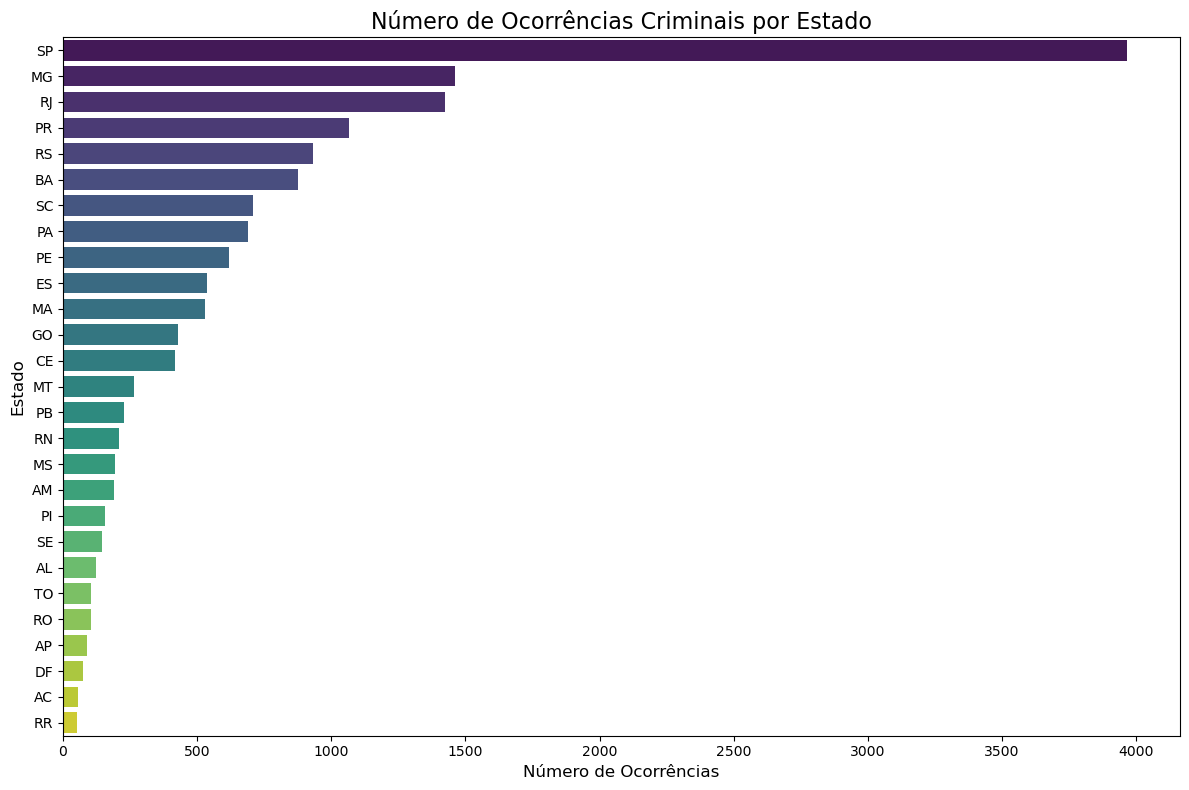

In [6]:
plt.figure(figsize=(12, 8))
sns.countplot(y=df_mod['estado'], order=df_mod['estado'].value_counts().index, palette='viridis')
plt.title('Número de Ocorrências Criminais por Estado', fontsize=16)
plt.xlabel('Número de Ocorrências', fontsize=12)
plt.ylabel('Estado', fontsize=12)
plt.tight_layout()
plt.show()

Seleciono e exibo as 100 cidades com maior número de registros, para direcionar a análise aos municípios mais impactados.


/var/folders/bb/t3hfl2hd1gv6yy5d02vv55xr0000gn/T/ipykernel_5138/64790678.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_mod['cidade'], order=df_mod['cidade'].value_counts().iloc[:100].index, palette='mako')


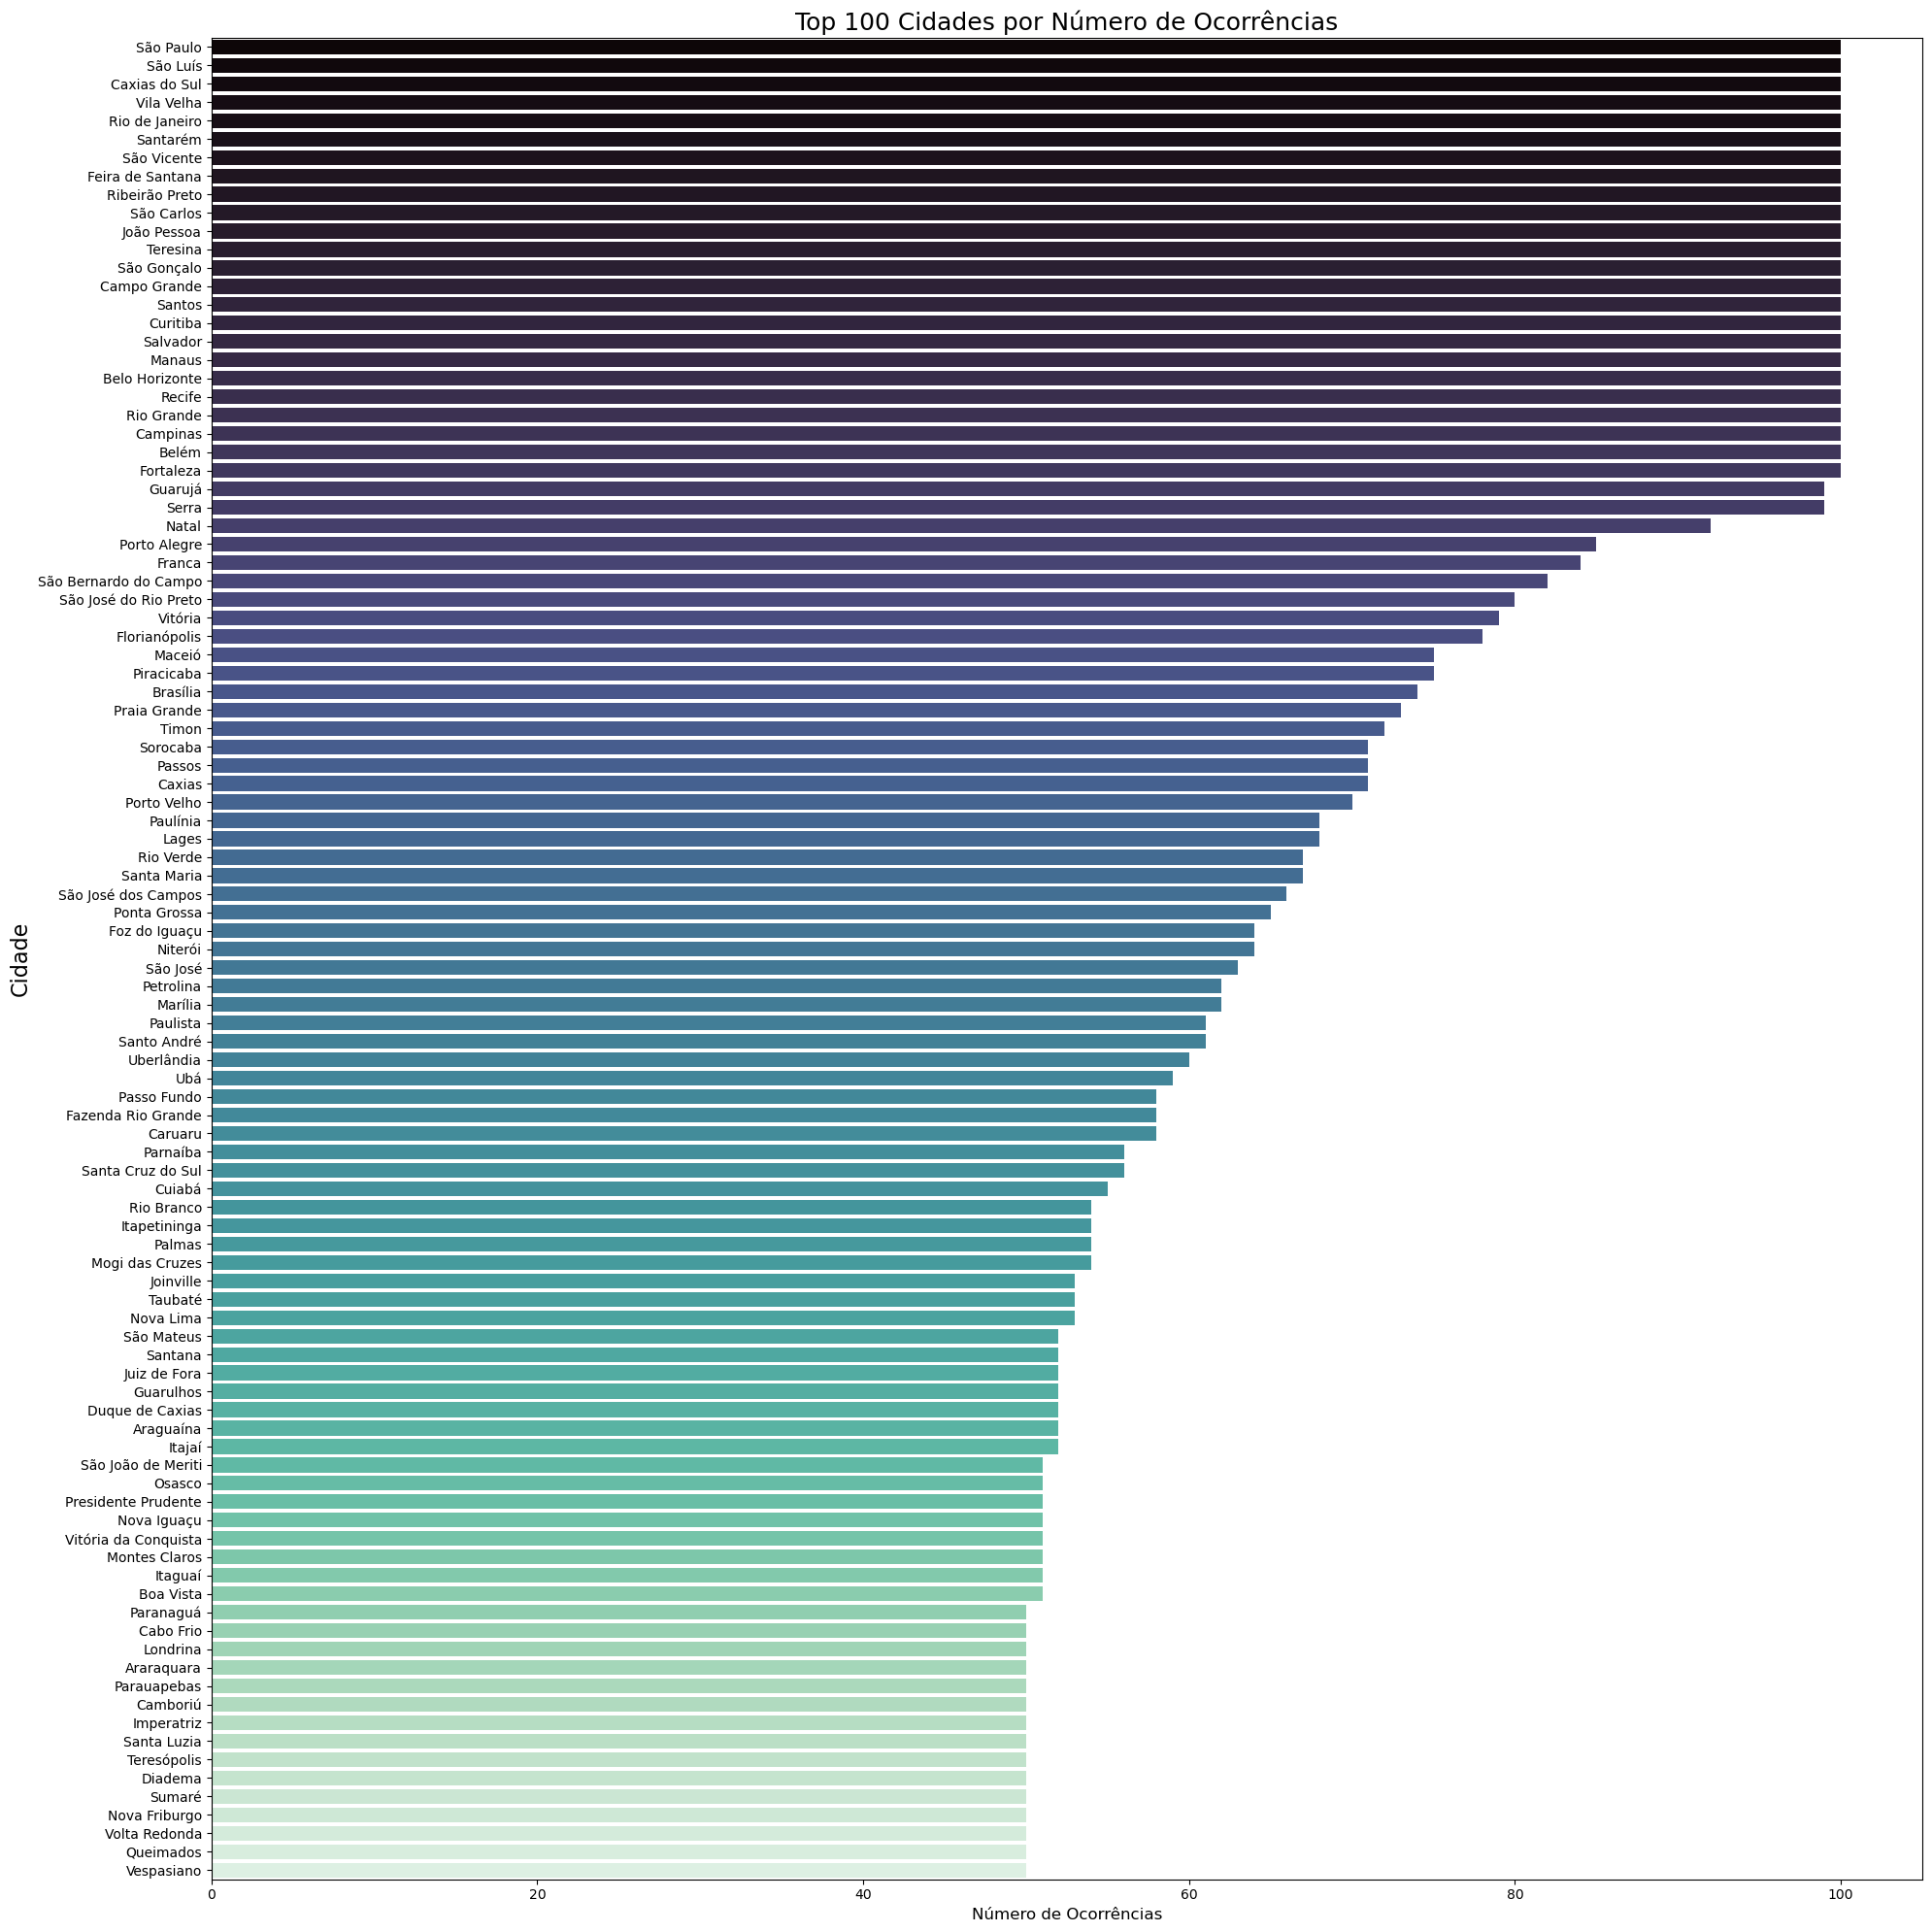

In [7]:
plt.figure(figsize=(20, 20))
sns.countplot(y=df_mod['cidade'], order=df_mod['cidade'].value_counts().iloc[:100].index, palette='mako')
plt.title('Top 100 Cidades por Número de Ocorrências', fontsize=18)
plt.xlabel('Número de Ocorrências', fontsize=12)
plt.ylabel('Cidade', fontsize=16)
plt.tight_layout()
plt.show()

### **Geração de Embeddings e Matriz de Similaridade Semântica**

Primeiro eu juntei todas as descrições limpas por cidade, criando um dicionário onde a chave é o nome do município e o valor é a lista de suas ocorrências. Aí transformei esse mapa numa lista única de strings (todas_as_descricoes) e numa lista paralela indicando a que cidade cada descrição pertence (mapa_indices_para_cidade).

Em seguida, usei o SBERT (paraphrase-multilingual-mpnet-base-v2) para gerar embeddings em lote das descrições — ficou muito mais rápido que rodar um a um. Depois, reagrupando pelo índice da cidade, empilhei os embeddings de cada município em tensores, assim cada cidade tem seu próprio tensor [n_descrições, dim_embedding].

Com os embeddings prontos, calculei a similaridade de cosseno entre cada par de cidades. Para não produzir redundância, limitei o laço a i ≤ j e tratei a similaridade de uma cidade consigo mesma como 1.0. Peguei o valor máximo daquela matriz de pares de descrições para representar a similaridade “cidade <-> cidade”. Organizei tudo num DataFrame quadrado df_similaridade, preenchendo zeros onde não há conexão.

Por fim, mostrei uma amostra 5×5 da matriz para inspeção rápida e, depois, plotei um heatmap só das 100 cidades com mais ocorrências. Esse mapa destaca visualmente quais municípios têm descrições de crimes semanticamente mais parecidas — é a base para, depois, decidir o limiar e construir o grafo.

Calculo a similaridade de cosseno entre as representações de cada cidade, resultando numa matriz que mostra o grau de semelhança entre todos os pares.


In [9]:
# inicio o cálculo de similaridade semântica entre as cidades que têm embeddings
# dicionário que vai guardar, para cada cidade, a similaridade com as demais
descricoes_por_cidade_limpas = {}
for _, row in df_mod.iterrows():
    cid = row['cidade']
    desc_limpa = row['descricao_limpa']
    if cid not in descricoes_por_cidade_limpas:
        descricoes_por_cidade_limpas[cid] = []
    if isinstance(desc_limpa, str) and desc_limpa.strip():
        descricoes_por_cidade_limpas[cid].append(desc_limpa)

cidade_para_estado = dict(zip(df_mod['cidade'], df_mod['estado']))
grp_municipios = sorted(list(descricoes_por_cidade_limpas.keys()))

todas_as_descricoes = []
mapa_indices_para_cidade = []
for cid in grp_municipios:
    for desc in descricoes_por_cidade_limpas[cid]:
        todas_as_descricoes.append(desc)
        mapa_indices_para_cidade.append(cid)

print(f"\nGerando embeddings para {len(todas_as_descricoes)} descrições em {len(grp_municipios)} cidades...")

modelo_st_emb = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
embeddings_completos = modelo_st_emb.encode(todas_as_descricoes,convert_to_tensor=True,show_progress_bar=True,batch_size=32)

print("--- Encoding em lote concluído. Re-agrupando por cidade... ---")

emb_por_cidade_limpas = {cid: [] for cid in grp_municipios}
for i, embedding in enumerate(embeddings_completos):
    cidade_correspondente = mapa_indices_para_cidade[i]
    emb_por_cidade_limpas[cidade_correspondente].append(embedding)

for cid in grp_municipios:
    if emb_por_cidade_limpas[cid]:
        emb_por_cidade_limpas[cid] = torch.stack(emb_por_cidade_limpas[cid])
    else:
        del emb_por_cidade_limpas[cid]

print("--- Geração de embeddings concluída. ---")
if grp_municipios:
    primeira_cidade = grp_municipios[0]
    print(f"\nAmostra de embedding para a cidade: {primeira_cidade} (tensor de {emb_por_cidade_limpas[primeira_cidade].shape})")


Gerando embeddings para 15636 descrições em 318 cidades...


Batches:   0%|          | 0/489 [00:00<?, ?it/s]

--- Encoding em lote concluído. Re-agrupando por cidade... ---
--- Geração de embeddings concluída. ---

Amostra de embedding para a cidade: Abaetetuba (tensor de torch.Size([30, 768]))



Matriz de Similaridade (amostra de 5x5 cidades):
                     Abaetetuba  Alagoinhas  Almirante Tamandaré  Altamira  \
Abaetetuba             1.000000    0.000000             0.000000  0.000000   
Alagoinhas             0.696417    1.000000             0.000000  0.000000   
Almirante Tamandaré    0.711329    0.665080             1.000000  0.000000   
Altamira               0.726991    0.780877             0.999999  1.000000   
Alvorada               0.598845    0.655370             0.747842  0.677425   

                     Alvorada  
Abaetetuba                0.0  
Alagoinhas                0.0  
Almirante Tamandaré       0.0  
Altamira                  0.0  
Alvorada                  1.0  

Visualizando a similaridade entre as 100 cidades com mais ocorrências...


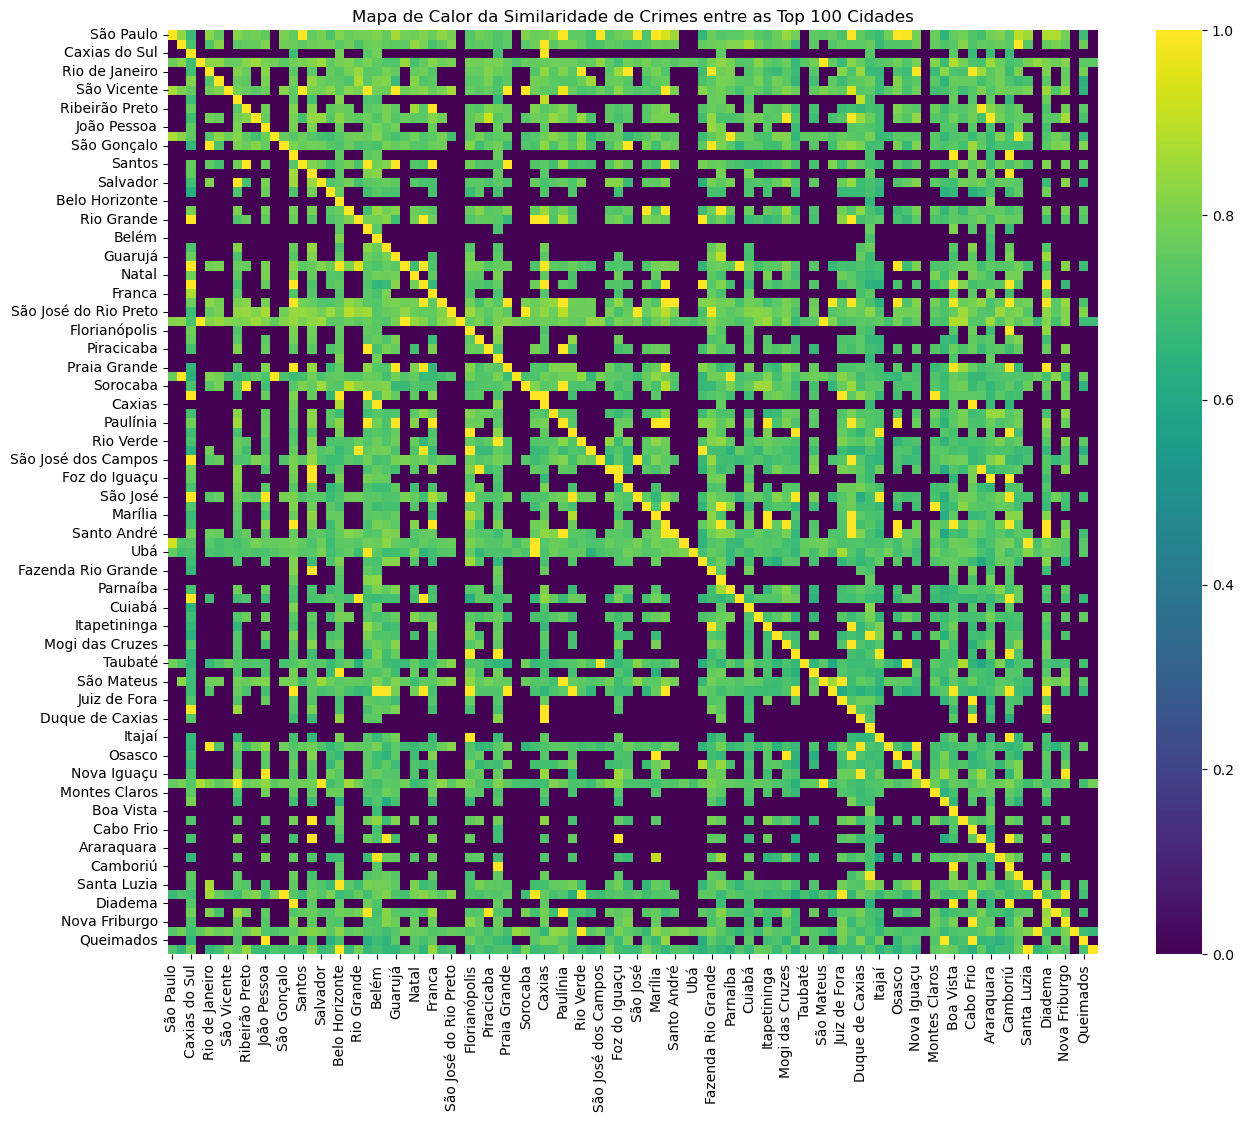

In [10]:
# dicionário que vai guardar, para cada cidade, a similaridade com as demais
similarity_scores = {}
# filtro só as cidades com embedding gerado
grp_municipios_com_emb = [cid for cid in grp_municipios if cid in emb_por_cidade_limpas]

# percorro cada par de cidades (i ≤ j) para calcular a similaridade
for i, cid1 in enumerate(grp_municipios_com_emb):
    similarity_scores[cid1] = {}
    for j in range(i, len(grp_municipios_com_emb)):
        cid2 = grp_municipios_com_emb[j]

        # similaridade de uma cidade com ela mesma é 1
        if i == j:
            similarity_scores[cid1][cid2] = 1.0
            continue

        # recupero os embeddings (tensor [n_descrs, dim]) de cada cidade
        embeddings1 = emb_por_cidade_limpas[cid1]
        embeddings2 = emb_por_cidade_limpas[cid2]

        # matiz de similaridade coseno entre todas as descrições
        similaridade_matriz = util.cos_sim(embeddings1, embeddings2)

        # pego o valor máximo: a descrição mais parecida entre as duas cidades
        max_similarity = torch.max(similaridade_matriz).item()

        # salvo no dicionário e mantenho a simetria
        similarity_scores[cid1][cid2] = max_similarity
        if cid2 not in similarity_scores:
            similarity_scores[cid2] = {}
        similarity_scores[cid2][cid1] = max_similarity

# converto para DataFrame e preencho valores faltantes com 0
df_similaridade = pd.DataFrame(similarity_scores).fillna(0)

# mostro uma amostra 5×5 para inspecionar rapidamente os valores
print("\nMatriz de Similaridade (amostra de 5x5 cidades):")
print(df_similaridade.iloc[:5, :5])

# pego as 100 cidades com mais ocorrências pra visualizar o heatmap
print("\nVisualizando a similaridade entre as 100 cidades com mais ocorrências...")
cidades_mais_frequentes = df_mod['cidade'].value_counts().head(100).index.tolist()
df_similaridade_subset = df_similaridade.loc[cidades_mais_frequentes, cidades_mais_frequentes]

# heatmap só das top 100 para destacar padrões de semelhança
plt.figure(figsize=(15, 12))
sns.heatmap(df_similaridade_subset, cmap="viridis", annot=False)
plt.title("Mapa de Calor da Similaridade de Crimes entre as Top 100 Cidades")
plt.show()

### **Construção do Grafo de Similaridade e Análise de Conectividade**

Nesta etapa, transformei a matriz de similaridade em um grafo não direcionado, conectando apenas os pares de cidades cuja similaridade ultrapassa um limiar que escolhi empiricamente (0.85, o maior valor que conservava a propriedade de ser conexo). Cada nó guarda o atributo do estado correspondente, e cada aresta carrega o peso igual ao próprio score de similaridade.

Depois de adicionar todos os nós e arestas:
-	Imprimo o número total de cidades e de conexões no grafo.
-	Esse grafo serve de base para entender a estrutura de comunidades semânticas de crimes entre municípios.

### **Distribuição dos Scores de Similaridade**

Para justificar o valor de limiar = 0.85, extraí apenas uma vez cada par de similaridades (triângulo inferior da matriz) e plotei um histograma de 50 bins:
-	A barra vertical vermelha indica onde 0.85 está na distribuição.
-	Com isso, vejo se estou cortando a lateral direita e quantos pares vão realmente virar aresta.
-   Além disso, como mencionei, eu testei e foi o maior valor que encontrei que ainda permitisse o grafo ser conexo naturalmente.

Logo abaixo, imprimo estatísticas básicas (máximo, mínimo, média e mediana) para ter um panorama numérico da similaridade entre todas as cidades.

### **Matriz de Adjacência e Heatmap**

Converto o grafo em uma matriz de adjacência binária (1 para aresta, 0 caso contrário) usando nx.to_pandas_adjacency.
-	Exibo apenas as primeiras 15 linhas e colunas para não sobrecarregar a saída.
-	Em paralelo, mostro como seria gerar essa mesma matriz direto da matriz de similaridade, aplicando > limiar.

Depois, pego a ordem das cidades segundo o volume de ocorrências e ploto um heatmap completo da matriz de adjacência:
-	Isso revela visualmente blocos de cidades densamente interconectadas (potenciais comunidades de crime).

### **Checagem de Conectividade e Layout de Rede**

Verifico se o grafo é conexo ou não, anotando quantos componentes existem caso contrário (que nunca vai acontecer se ninguém colocar um limiar acima dos 0.85 que estabeleci).

Por fim, faço uma visualização do grafo.

Com esses gráficos e matrizes, tenho um panorama completo de como as cidades se agrupam semanticamente pelas descrições de crimes, pronto para avançar para a parte final da atividade 2, a modelagem da matriz estacionária.

In [11]:
# defino o limiar de similaridade acima do qual cidades serão conectadas
limiar = 0.85

# crio um grafo vazio e adiciono cada cidade como nó, guardando o estado como atributo
G = nx.Graph()
for cidade in grp_municipios_com_emb:
    G.add_node(cidade, estado=cidade_para_estado.get(cidade, 'N/A'))

# percorro cada par de cidades (cid1, cid2) e adiciono uma aresta se a similaridade passar do limiar
for cid1 in grp_municipios_com_emb:
    for cid2 in grp_municipios_com_emb:
        if cid1 == cid2:
            continue  # pulo auto-similaridade
        score = df_similaridade.at[cid1, cid2]
        if score > limiar:
            # peso da aresta é a própria similaridade máxima entre descrições
            G.add_edge(cid1, cid2, weight=score)

print(f"Número de Cidades: {G.number_of_nodes()}")
print(f"Número de Conexões: {G.number_of_edges()}")

Número de Cidades: 318
Número de Conexões: 2085


Ploto um histograma da distribuição dos scores de similaridade entre pares de cidades, destacando o limiar usado para conectar os nós no grafo.


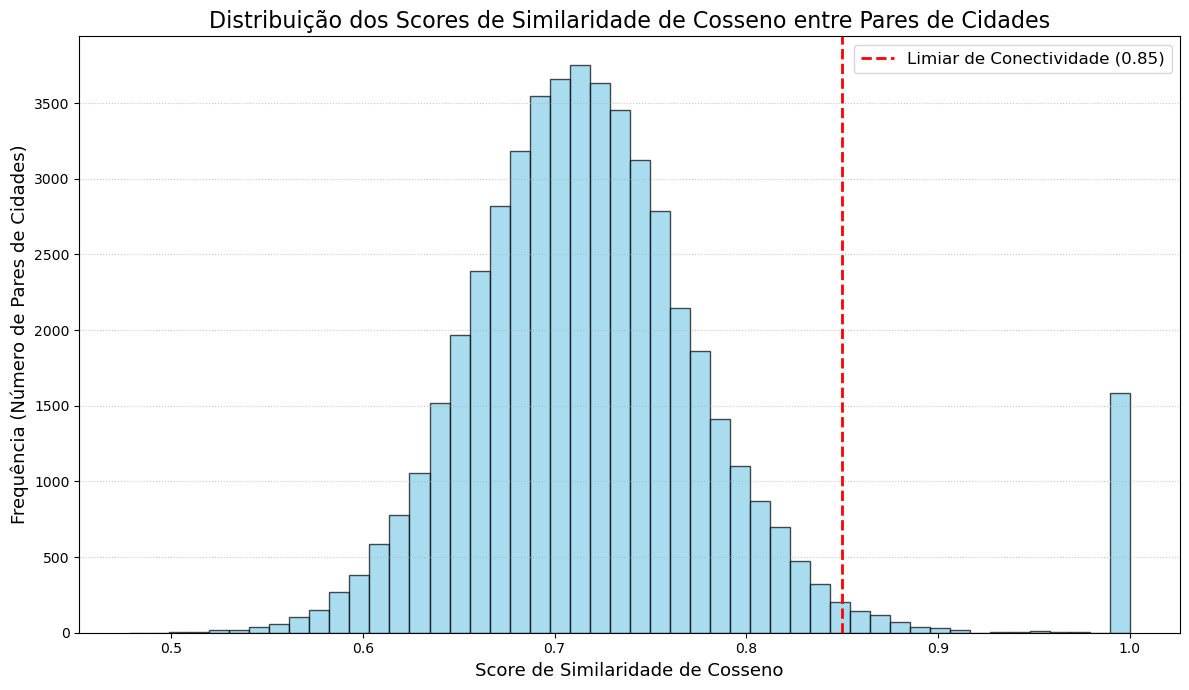


Valor Máximo de Similaridade: 1.0000
Valor Mínimo de Similaridade: 0.4782
Valor Médio de Similaridade: 0.7230
Mediana da Similaridade: 0.7151


In [12]:
# eu quero olhar a distribuição dos scores só uma vez por par, então pego o triângulo INFERIOR da matriz
matriz_numerica = df_similaridade.values
# corrigido: uso tril (lower) e k=-1 pra excluir a diagonal principal
indices_np = np.tril_indices_from(matriz_numerica, k=-1)
scores_para_plotar = matriz_numerica[indices_np]

# agora ploto o histograma desses scores
plt.figure(figsize=(12, 7))
plt.hist(
    scores_para_plotar,
    bins=50,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)
# adiciono uma linha vertical pra mostrar onde fica o limiar de conexão
plt.axvline(
    limiar,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'Limiar de Conectividade ({limiar})'
)
plt.title('Distribuição dos Scores de Similaridade de Cosseno entre Pares de Cidades', fontsize=16)
plt.xlabel('Score de Similaridade de Cosseno', fontsize=13)
plt.ylabel('Frequência (Número de Pares de Cidades)', fontsize=13)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# por fim, imprimo algumas estatísticas básicas pra entender melhor os dados
print(f"\nValor Máximo de Similaridade: {scores_para_plotar.max():.4f}")
print(f"Valor Mínimo de Similaridade: {scores_para_plotar.min():.4f}")
print(f"Valor Médio de Similaridade: {scores_para_plotar.mean():.4f}")
print(f"Mediana da Similaridade: {np.median(scores_para_plotar):.4f}")

Converto o grafo em matriz de adjacência para visualizar de forma tabular as conexões (1 para ligação, 0 caso contrário).


In [13]:
# converto o grafo em DataFrame com 1 onde existe aresta e 0 onde não existe
# usando o NetworkX to_pandas_adjacency, já passo dtype=int pra ficar binário
matriz_adjacencia = nx.to_pandas_adjacency(G, dtype=int)

print("Matriz de Adjacências Final (15 cidades):")
# como a matriz completa pode ser enorme, mostro só as 15 primeiras linhas/colunas
print(matriz_adjacencia.iloc[:15, :15])


# também dá pra gerar a matriz direto da tabela de similaridade:
# aqui marco 1 quando o score > limiar e 0 caso contrário
matriz_adjacencia_binaria = (df_similaridade > limiar).astype(int)
print("\nMatriz de Adjacências Binária (criada a partir do df_similaridade):")
print(matriz_adjacencia_binaria.iloc[:15, :15])

Matriz de Adjacências Final (15 cidades):
                      Abaetetuba  Alagoinhas  Almirante Tamandaré  Altamira  \
Abaetetuba                     0           0                    0         0   
Alagoinhas                     0           0                    0         0   
Almirante Tamandaré            0           0                    0         0   
Altamira                       0           0                    0         0   
Alvorada                       0           0                    0         0   
Americana                      0           0                    0         0   
Ananindeua                     0           0                    0         1   
Angra dos Reis                 0           0                    0         0   
Anápolis                       0           0                    0         0   
Aparecida de Goiânia           0           0                    0         0   
Apucarana                      0           0                    0         0   
Aracaju   

Exibo um mapa de calor da matriz de adjacência, facilitando a identificação de grupos de cidades fortemente conectadas.


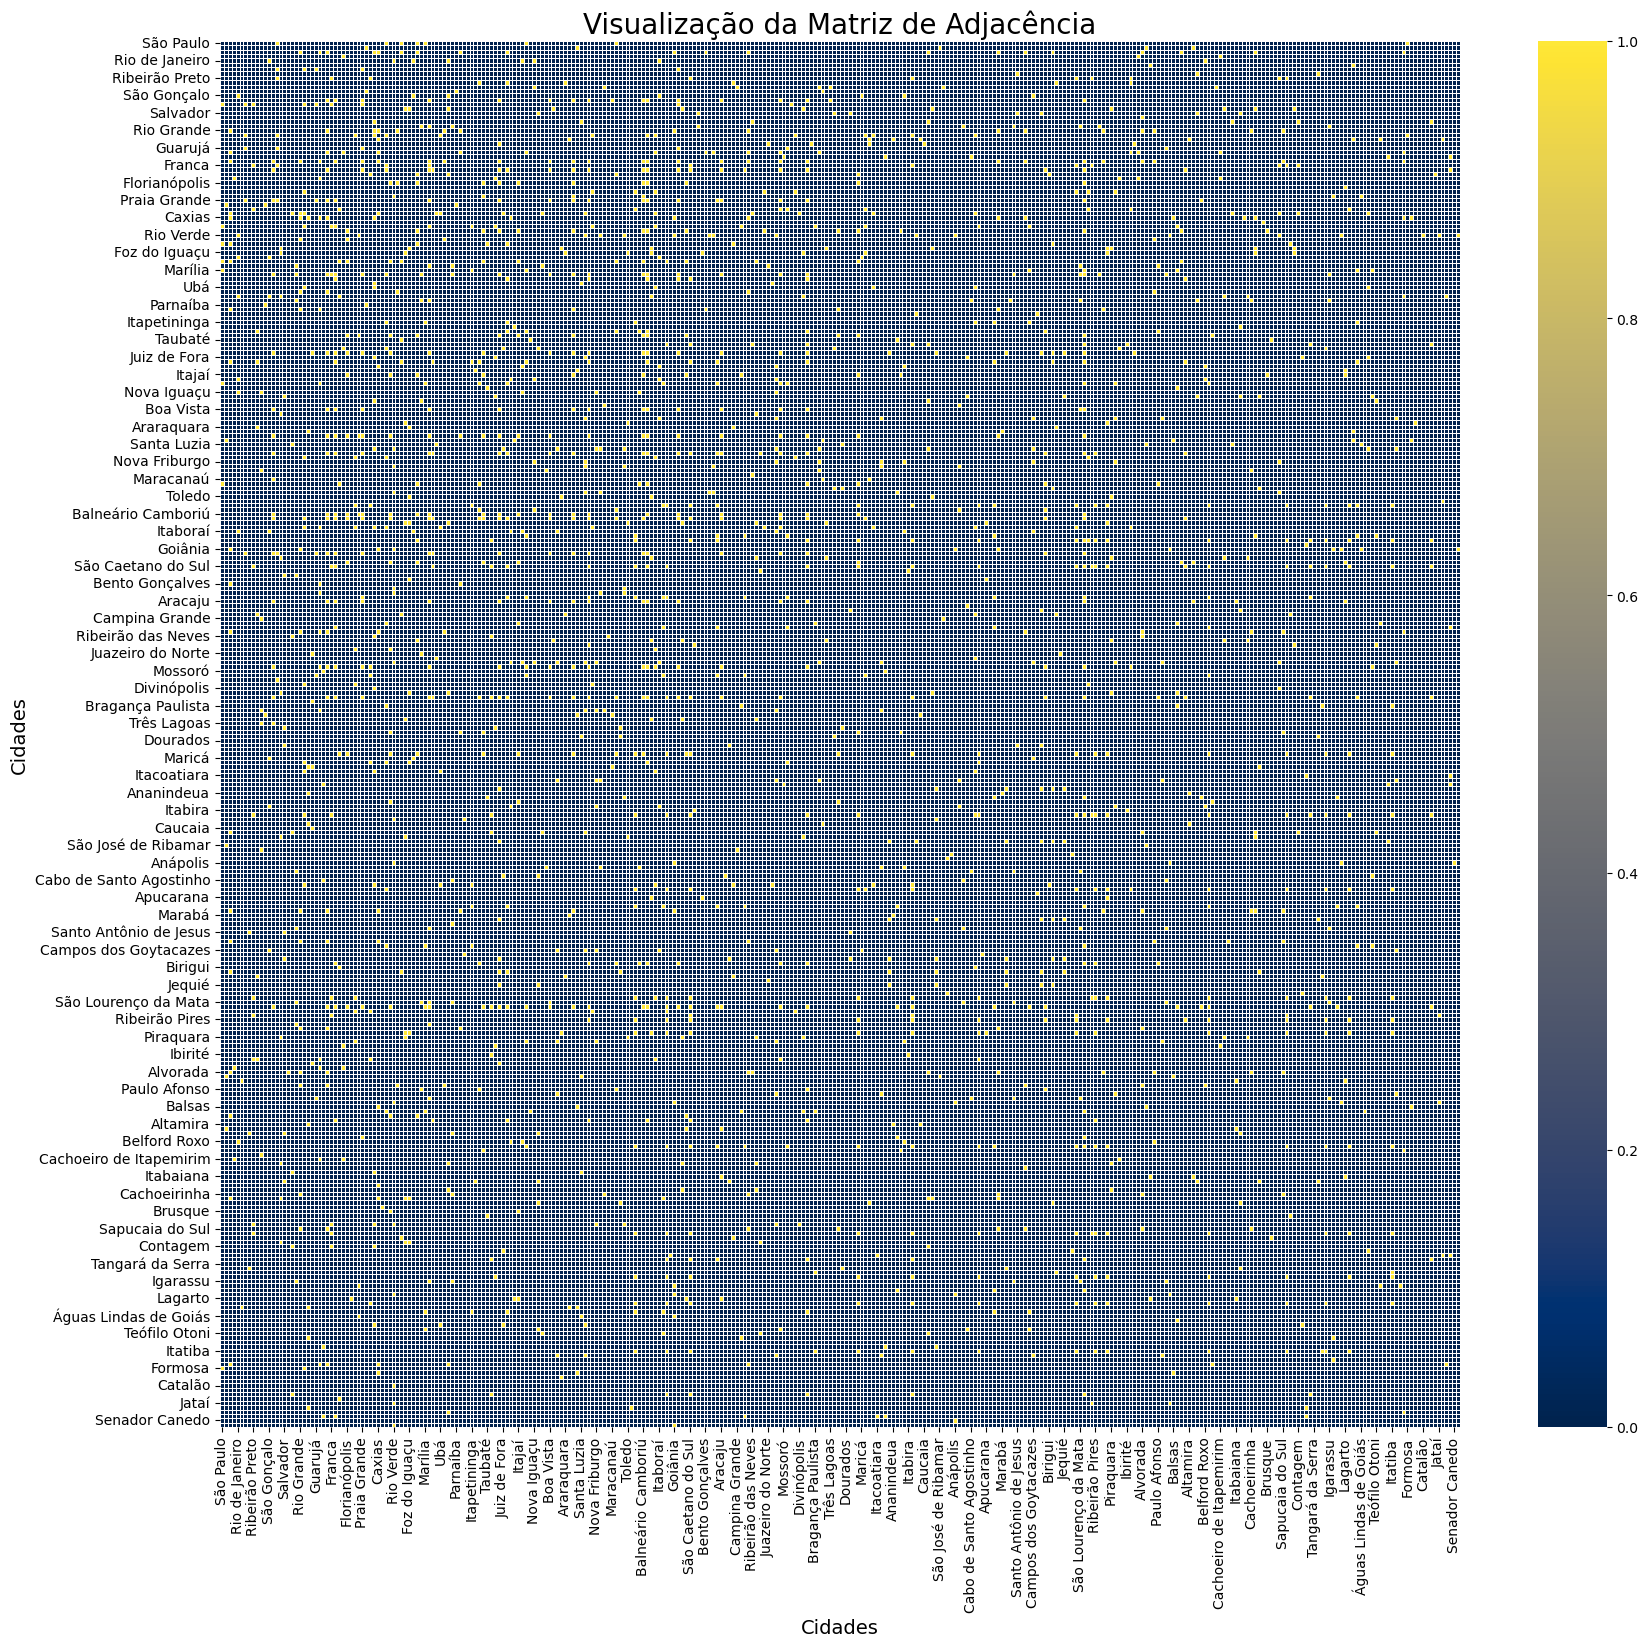

In [14]:
# seleciono as cidades na ordem de ocorrência para manter consistência na visualização
cidades = df_mod['cidade'].value_counts().index
# crio um sub-conjunto da matriz de adjacência só com essas cidades
sub_matriz_adjacencia = matriz_adjacencia.loc[cidades, cidades]

# ploto o heatmap da matriz de adjacência inteira pra ver os clusters
plt.figure(figsize=(20, 18))
sns.heatmap(
    sub_matriz_adjacencia,
    cmap='cividis',
    linewidths=.5  # traços finos pra separar células
)
plt.title('Visualização da Matriz de Adjacência', fontsize=20)
plt.xlabel('Cidades', fontsize=14)
plt.ylabel('Cidades', fontsize=14)
plt.show()

Verifico se o grafo é totalmente conectado ou se há componentes isolados, informando quantos subgrafos independentes existem.


In [15]:
# testo se o grafo é conexo ou não
if nx.is_connected(G):
    print("G é conexo.")
else:
    num_componentes = nx.number_connected_components(G)
    print(f"G não conexo. {num_componentes} componentes")

G é conexo.


Desenho o grafo com layout Kamada–Kawai, destacando nós com maior grau e ajustando a espessura das arestas conforme o peso de similaridade.


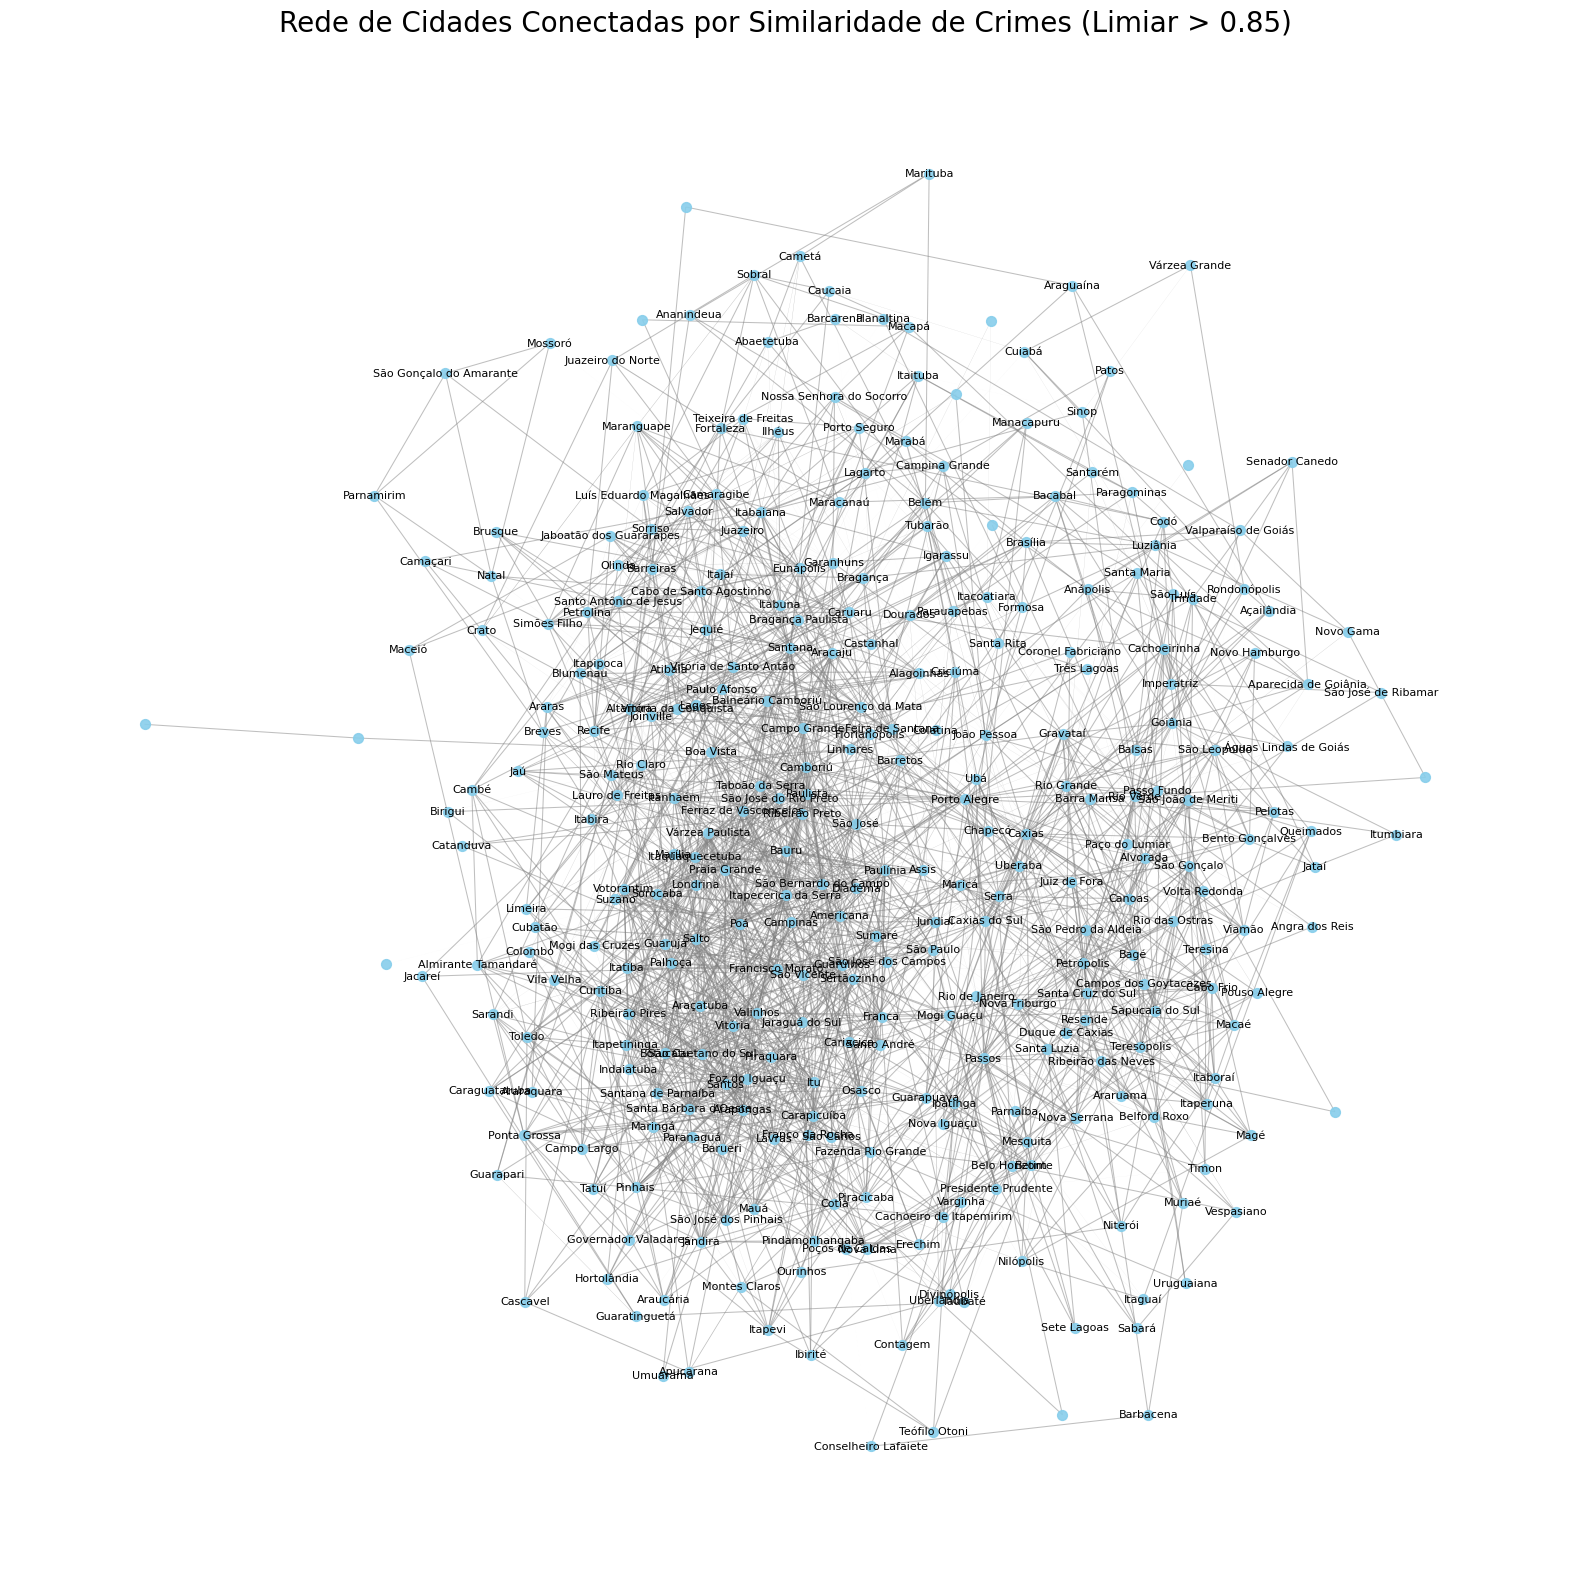

In [16]:
plt.figure(figsize=(20, 20))

# calculo posições dos nós com layout Kamada-Kawai (boa separação visual)
pos = nx.kamada_kawai_layout(G)

# extraio pesos das arestas para ajustar a largura no desenho
edge_weights = [d['weight'] for (_, _, d) in G.edges(data=True)]

# desenho os nós pequenos e azuis
nx.draw_networkx_nodes(
    G, pos,
    node_size=50,
    node_color='skyblue',
    alpha=0.9
)

# desenho as arestas, largura proporcional à força de similaridade acima do limiar
nx.draw_networkx_edges(
    G, pos,
    width=[(w - limiar) * 5 for w in edge_weights],
    alpha=0.5,
    edge_color='gray'
)

# decido quais rótulos desenhar: apenas nós com grau alto (1% do total ou no mínimo 2)
degree_threshold = max(2, int(G.number_of_nodes() * 0.01))
labels_to_draw = {node for node, degree in G.degree() if degree >= degree_threshold}
labels = {node: node for node in labels_to_draw}

# se nenhum nó passar no threshold, pego os top 10 por grau para não deixar o grafo sem rótulos
if not labels:
    top_degree_nodes = sorted(G.degree, key=lambda item: item[1], reverse=True)[:10]
    labels = {node: node for node, _ in top_degree_nodes}

nx.draw_networkx_labels(
    G, pos,
    labels=labels,
    font_size=8,
    font_color='black'
)

plt.title(
    f"Rede de Cidades Conectadas por Similaridade de Crimes (Limiar > {limiar})",
    fontsize=20
)
plt.axis('off')
plt.show()

### **Modelagem da Cadeia de Markov e Rankings de Risco**
Aqui eu uso a estrutura de grafo semântico de crimes para calcular um score de risco para cada cidade. A ideia é:

1.	Matriz de Transição

-	Converto o grafo de similaridades em uma matriz NumPy, onde cada linha soma ao grau do nó.
-	Divido cada linha pela soma para obter P[i,j] = A[i,j] / grau(i). Essa é a probabilidade de “passar” de i para j em um passo do modelo.

2.	Distribuição Estacionária como Risco

-	Começo com uma distribuição uniforme e aplico o método das potências (π ← π·P) até convergir.
-	O vetor resultante π tem um valor para cada cidade: quanto maior π[cidade], maior o seu risco estimado de ocorrência futura, segundo o padrão de similaridade de crimes.

3.	Ranking e Comparação

-	Crio um DataFrame ordenado pelos maiores valores de π e listo o Top 20 para destacar as cidades com maior risco relativo.
-	Em paralelo, obtenho o ranking bruto pelo número de ocorrências registradas e misturo ambos num df_comparativo. Assim, posso comparar quem aparece no topo pelo histórico de volume e quem aparece pelo padrão de rede semântica.

4.	Visualização de Risco

-	Com as 40 cidades de maior π, faço um barplot horizontal que mostra o “risco estimado” de cada município.
-	Esse gráfico dá uma visão clara de quais cidades, pela estrutura global de similaridade de crimes, merecem mais atenção para monitoramento e prevenção.

Dessa forma, uso a teoria de cadeias de Markov como uma ferramenta de análise de risco, em que a probabilidade estacionária indica a centralidade de cada cidade no padrão de eventos criminais e, portanto, o seu potencial de vulnerabilidade a novos casos.

In [17]:
# converto o grafo em uma matriz NumPy para poder montar a cadeia de Markov
matriz_adjacencia_np = nx.to_numpy_array(G)
# listo as cidades na mesma ordem das linhas/colunas da matriz
lista_cidades_ordenada = list(G.nodes())

# construo a matriz de transição: cada linha i soma ao grau(i), e P[i,j] = A[i,j] / grau(i)
graus = matriz_adjacencia_np.sum(axis=1)
# evito divisão por zero em nós isolados trocando grau 0 por 1 (linha inteira já é zero mesmo)
graus[graus == 0] = 1
matriz_transicao = matriz_adjacencia_np / graus[:, np.newaxis]

# agora calculo a distribuição estacionária π usando o método das potências
num_cidades = len(lista_cidades_ordenada)
# começo com uma distribuição uniforme
pi = np.ones(num_cidades) / num_cidades
num_iteracoes = 100 # mas poderia ser menos, esta convervingo com 40~50

for i in range(num_iteracoes):
    pi_novo = pi.dot(matriz_transicao)
    # se convergir antes do fim, já posso parar o loop
    if np.allclose(pi, pi_novo):
        print(f"Convergência alcançada na iteração {i+1}.")
        break
    pi = pi_novo

# normalizo no final pra garantir soma = 1
pi = pi / pi.sum()

# coloco tudo num DataFrame e ordeno pra ver quem tem maior chance segundo o modelo
df_resultados = pd.DataFrame({
    'Cidade':   lista_cidades_ordenada,
    'Probabilidade_Estacionaria': pi
})
df_resultados_ordenado = df_resultados.sort_values(
    by='Probabilidade_Estacionaria',
    ascending=False
)

print("\n--- Top 20 Cidades com Maior Probabilidade de Ocorrência Futura ---")
print(df_resultados_ordenado.head(20))

Convergência alcançada na iteração 49.

--- Top 20 Cidades com Maior Probabilidade de Ocorrência Futura ---
                    Cidade  Probabilidade_Estacionaria
224                    Poá                    0.011452
207               Paulista                    0.011350
130   Itapecerica da Serra                    0.010290
242                  Salto                    0.008829
249                Santana                    0.008796
220           Porto Alegre                    0.008622
196                Palhoça                    0.008615
316        Várzea Paulista                    0.008290
97   Ferraz de Vasconcelos                    0.008032
103       Francisco Morato                    0.007964
209               Paulínia                    0.007936
56                Camboriú                    0.007889
268  São Bernardo do Campo                    0.007779
113              Guarulhos                    0.007652
15               Arapongas                    0.007624
74          

In [18]:
df_resultados_ordenado

Cidade  Probabilidade_Estacionaria
224                   Poá                    0.011452
207              Paulista                    0.011350
130  Itapecerica da Serra                    0.010290
242                 Salto                    0.008829
249               Santana                    0.008796
..                    ...                         ...
168                Manaus                    0.000458
14              Arapiraca                    0.000432
222           Porto Velho                    0.000247
206        Patos de Minas                    0.000213
234            Rio Branco                    0.000211

[318 rows x 2 columns]

Comparo o ranking baseado na probabilidade estacionária com o ranking pelo volume bruto de ocorrências, para identificar diferenças entre impacto e frequência.

In [19]:
# gero um ranking das cidades por número bruto de ocorrências
ranking_ocorrencias = df_mod['cidade'].value_counts().reset_index()
ranking_ocorrencias.columns = ['Cidade', 'Numero_Ocorrencias']

# uni o ranking de Markov com o ranking de num de ocorrencias pra comparar lado a lado
df_comparativo = pd.merge(
    df_resultados_ordenado,         # probabilidades estacionárias já ordenadas
    ranking_ocorrencias,            # volume de ocorrências
    on='Cidade',
    how='left'                      # mantenho todas as cidades do modelo de Markov
)

# imprimo os dois rankings para ver diferenças e semelhanças
print("--- Comparativo de Rankings ---")

print("\nTOP 20 CIDADES POR PROBABILIDADE ESTACIONÁRIA (MODELO DE MARKOV):")
print(
    df_comparativo[
        ['Cidade', 'Probabilidade_Estacionaria', 'Numero_Ocorrencias']
    ].head(20)
)

print("\n\nTOP 20 CIDADES POR NÚMERO DE OCORRÊNCIAS (VOLUME BRUTO):")
print(
    df_comparativo
    .sort_values(by='Numero_Ocorrencias', ascending=False)[
        ['Cidade', 'Probabilidade_Estacionaria', 'Numero_Ocorrencias']
    ].head(20)
)

--- Comparativo de Rankings ---

TOP 20 CIDADES POR PROBABILIDADE ESTACIONÁRIA (MODELO DE MARKOV):
                   Cidade  Probabilidade_Estacionaria  Numero_Ocorrencias
0                     Poá                    0.011452                  48
1                Paulista                    0.011350                  61
2    Itapecerica da Serra                    0.010290                  41
3                   Salto                    0.008829                  49
4                 Santana                    0.008796                  52
5            Porto Alegre                    0.008622                  85
6                 Palhoça                    0.008615                  47
7         Várzea Paulista                    0.008290                  45
8   Ferraz de Vasconcelos                    0.008032                  49
9        Francisco Morato                    0.007964                  29
10               Paulínia                    0.007936                  68
11           

Ploto um gráfico de barras com as 40 cidades de maior risco estimado (probabilidade estacionária), permitindo comparar rapidamente os principais pontos críticos.


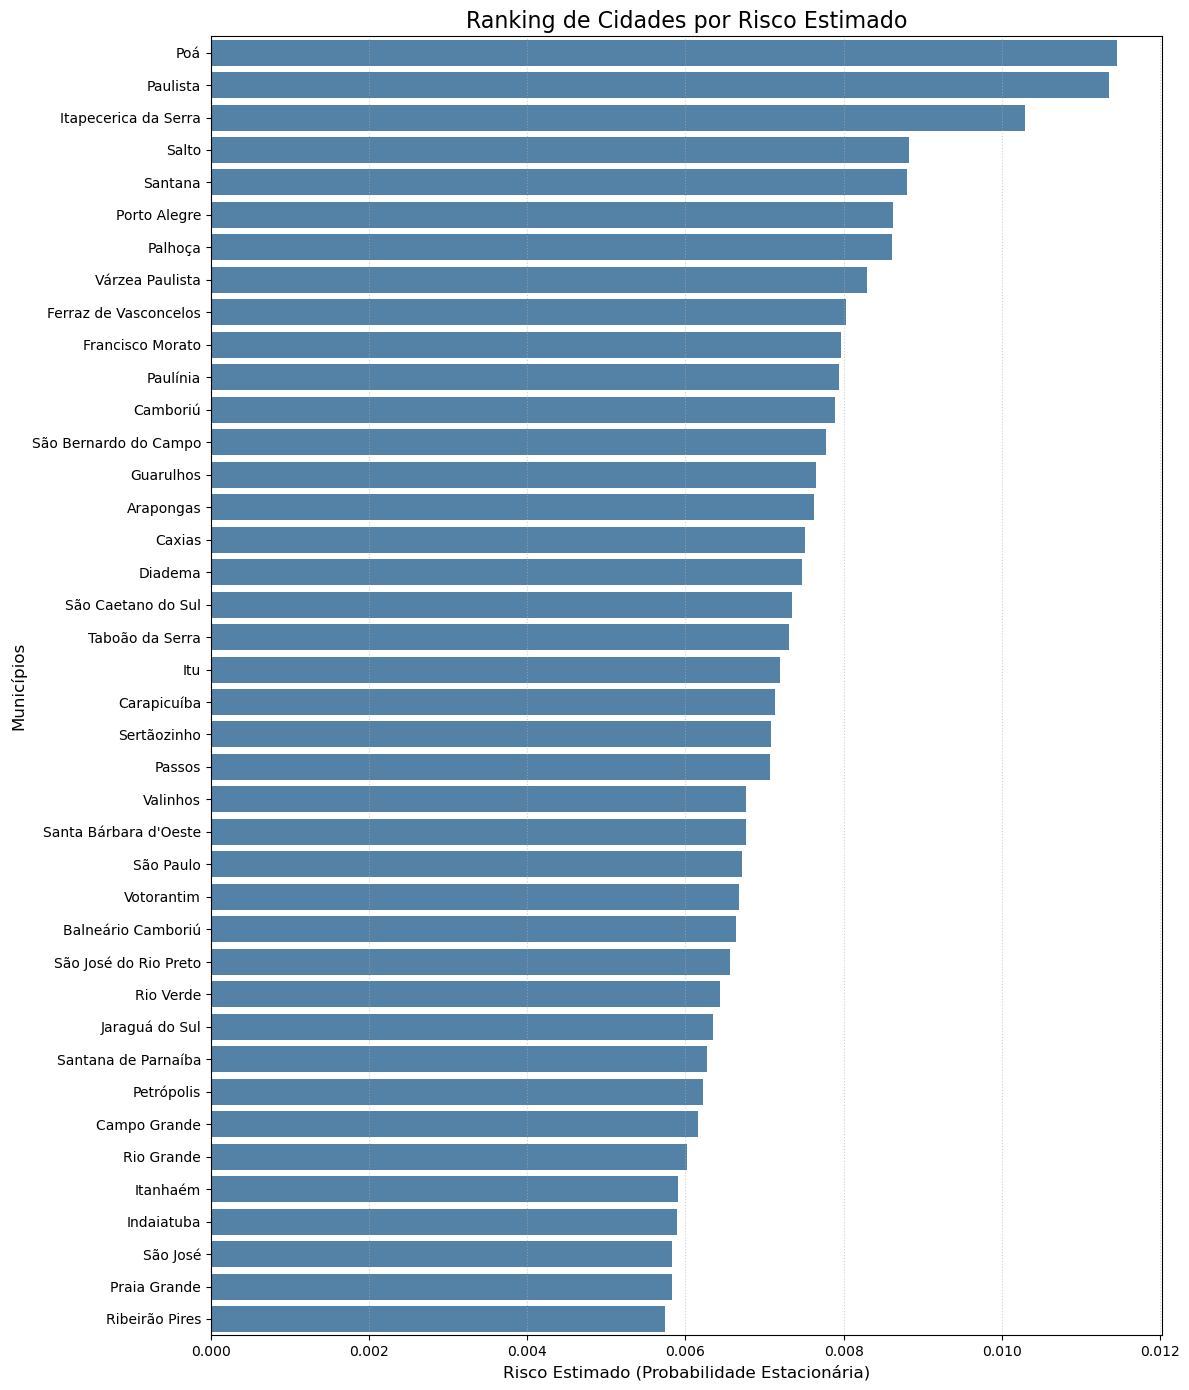

In [20]:
# crio um DataFrame só com as 40 cidades de maior risco (probabilidade estacionária)
df_ranking = df_comparativo.sort_values(
    by='Probabilidade_Estacionaria',
    ascending=False
).head(40)

plt.figure(figsize=(12, 14))
sns.barplot(
    x='Probabilidade_Estacionaria',
    y='Cidade',
    data=df_ranking,
    color='steelblue'
)

# ajusto título e eixos para deixar claro o que cada gráfico representa
plt.title('Ranking de Cidades por Risco Estimado', fontsize=16)
plt.xlabel('Risco Estimado (Probabilidade Estacionária)', fontsize=12)
plt.ylabel('Municípios', fontsize=12)
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# **Atividade 3**
Nesta etapa eu parto do mesmo grafo de similaridade de descrições de assaltos e uso Label Propagation para revelar comunidades semânticas. A ideia é:

-	Detectar clusters no grafo onde as descrições compartilham padrões linguísticos.
-	Propagar rótulos a partir de algumas cidades-semente que já categorizam tipos de crime por palavra-chave, e deixar o algoritmo preencher o resto da rede.
-	Interpretar cada comunidade como um tipo predominante de crime, inspecionando exemplos de descrições em cada cluster para rotular qualitativamente: “Cluster X: crimes com arma branca”, “Cluster Y: furtos em veículos”, etc.
-   A abordagem que escolhi foi a semi-supervisionada, pois, apesar do limiar relativamente alto, uma propagação não supervisionada simples unia todos os nós em um só cluster.

No final, apresento:

1.	Um grafo colorido por clusters, mostrando visualmente as comunidades.

2.	Uma tabela com exemplos de descrições em cada cluster, que ajuda a entender que tipo de crime aquele grupo representa.

3.	visualização textual dos padrões recorrentes de crime, detectados automaticamente a partir da similaridade semântica das descrições, em cada cluster.

### **Frequência de Palavras nas Descrições Limpas**

Primeiro juntei todo o texto limpo das descrições de crimes em uma única string e quebrei em tokens simples. Com o Counter, contei quantas vezes cada palavra apareceu e montei um DataFrame com as 30 palavras mais frequentes. Isso me dá um panorama rápido das expressões e termos que mais aparecem nas ocorrências — por exemplo, “arma”, “roubo”, “morte” etc. — e ajuda a validar se a limpeza de texto e o pré-processamento estão funcionando como esperado.

### **Escolha das Cidades-Semente para Propagação de Rótulos**

Com base nas listas de palavras-chave para cada categoria de crime (armas de fogo, furto/roubo, homicídio, armas brancas, assaltos), percorri as descrições originais por cidade e contei quantas vezes essas palavras-chave ocorrem. Para cada categoria, selecionei até três cidades que mais mencionam seus termos como “sementes” iniciais. Essas cidades-sementes são usadas como ponto de partida no algoritmo de propagação semi-supervisionada, garantindo que cada cluster comece já com exemplos claros do tipo de crime que representa.

### **Propagação de Rótulos com Markov Label Propagation**

A ideia aqui foi usar a matriz de transição da cadeia de Markov (a mesma que gerou π) para propagar os rótulos iniciais por todo o grafo.
1.	Converto o grafo em matriz de adjacência e depois em matriz de transição P.
2.	Crio uma matriz Y com zeros e marco 1.0 nas linhas correspondentes às cidades-sementes e suas categorias.
3.	Itero Y ← P·Y, mas a cada passo “fixo” de volta as sementes para manter o rótulo delas.
4.	No final, o rótulo de cada cidade é o índice da coluna de Y com maior valor.

Isso gera um array de labels finais e agrupa cada município em um cluster de crime tematicamente consistente.

### **Análise Qualitativa dos Clusters**

Para cada cluster identificado, juntei as cidades atribuídas e recuperei exemplos de até três descrições originais. Montei um DataFrame que lista:
-	ID e nome da categoria,
-	número total de cidades no cluster,
-	até cinco cidades de exemplo,
-	três ocorrências textuais para ilustrar o padrão de crime.

Esta tabela permite validar manualmente se cada comunidade faz sentido (“Cluster X realmente agrupa textos de roubos com arma?”, etc.) e serve de base para possíveis ajustes de palavras-chave ou de configuração do limiar.

### **Visualização dos Clusters no Grafo**

Para destacar visualmente as comunidades, criei um grafo auxiliar onde atribuí pesos altos às arestas intra-cluster (mesmo rótulo) e pesos baixos às inter-cluster. Aí usei um spring_layout ponderado para aproximar nós do mesmo cluster e afastar os demais. Cada nó ganhou a cor da sua categoria (ou cinza se não recebeu rótulo), e desenhei apenas os rótulos dos nós de maior grau para manter a legibilidade. O resultado é um mapa de cores que evidencia claramente as “ilhas” semânticas de crime — essencial para apresentar ao usuário final como os padrões emergiram da propagação de rótulos.

### **Detalhamento de Crimes por Cluster**

Por fim, percorri cada cluster e listei todas as descrições originais das cidades que pertencem a ele. No console aparecem:
-	O nome do cluster em destaque,
-	As cidades que o compõem,
-	E cada descrição numerada.

Isso deixa transparente quais textos formaram cada comunidade, ajudando a interpretar qualitativamente os padrões (“esse cluster agrupa estupros e violência sexual”, “aqui estão só furtos em carros”, etc.) antes de seguir para relatórios ou ações práticas.

In [21]:
# junto todo o texto limpo numa única string pra poder analisar a frequência
texto_completo_final = " ".join(df_mod['descricao_limpa'].dropna())

# quebro em tokens simples (split por espaço)
tokens = texto_completo_final.split()

# conto quantas vezes cada palavra aparece usando Counter
frequencia_palavras = Counter(tokens)

# mostro as Top 30 palavras mais recorrentes nas descrições limpas
print("\n--- Top 30 Palavras Mais Frequentes nas Descrições de Crimes Limpas ---")
df_frequencia = pd.DataFrame(
    frequencia_palavras.most_common(30),  # pego só as 30 primeiras
    columns=['Palavra', 'Frequência']
)
df_frequencia


--- Top 30 Palavras Mais Frequentes nas Descrições de Crimes Limpas ---


Palavra  Frequência
0     assalto        4188
1       roubo        1859
2     durante        1850
3        após        1847
4       preso        1517
5     Polícia        1452
6       morto        1325
7       tiros        1150
8    suspeito        1124
9   tentativa        1111
10      Homem        1102
11         PM        1008
12     prende         952
13      carro         890
14      morre         805
15  suspeitos         742
16     Grande         724
17    baleado         716
18   Suspeito         635
19     presos         631
20    polícia         603
21      crime         578
22       casa         561
23       anos         550
24     roubos         542
25      Civil         494
26        mil         471
27        diz         465
28      matar         464
29     contra         453

Defino categorias de crime e seleciono cidades “sementes” para cada classe com base em palavras-chave, preparando a análise semi-supervisionada.


In [22]:
from IPython.display import display

# mapeio as categorias de crime só pra usar no rótulo final e organizar
categorias_crime = {
    0: "Crimes com Armas de Fogo",
    1: "Furto/Roubo",
    2: "Crimes com Morte",
    3: "Armas Brancas",
    4: "Assaltos"
}
num_classes_crime = len(categorias_crime)

# defino listas de palavras-chave que identificam cada categoria
palavras_chave_categorias = {
    0: ["arma", "revólver", "pistola", "tiro", "armados", "confronto", "baleado", "tiros", "troca de tiros", "armada", "armas", "armado"],
    1: ["carro", "moto", "veículo", "automóvel", "roubo", "roubar", "prende", "presos", "roubos", "presa", "loja", "comércio", "estabelecimento", "caixa", "padaria", "farmácia", "roubado", "roubaram", "roubam", "roubou"],
    2: ["morte", "morto", "homicídio", "assassinato", "morre", "morta", "mortes", "mortos", "homicídio", "matam"],
    3: ["esfaqueamento", "arma branca", "faca", "facadas"],
    4: ["assaltada", "assalta", "assaltantes", "assaltar", "assaltos", "assalto", "assaltado", "assaltados"]
}

# agrupo as descrições originais por cidade para buscar palavras-chave
descricoes_por_cidade = {}
for _, row in df_ocorrencias.iterrows():
    cid = row['cidade']
    desc = row['descricao']
    # crio a lista se ainda não existir e adiciono a string não vazia
    if cid not in descricoes_por_cidade:
        descricoes_por_cidade[cid] = []
    if isinstance(desc, str) and desc.strip():
        descricoes_por_cidade[cid].append(desc)

# mapeio cidade → índice no vetor grp_municipios, para usar no rotulador
map_cidade_idx = {cidade: i for i, cidade in enumerate(grp_municipios)}

# vou guardar aqui o rótulo inicial de cada cidade-semente
rotulos_iniciais_map = {}
# e também a lista de cidades selecionadas como semente em cada categoria
cidades_semente_por_categoria = {cat_id: [] for cat_id in categorias_crime}
max_sementes_por_categoria = 3  # escolho até 3 cidades por categoria pra começar

# para cada categoria, procuro as cidades que mais mencionam suas palavras-chave
for cat_id, palavras_chave in palavras_chave_categorias.items():
    cidades_candidatas = []
    for cidade_idx, cidade_nome in enumerate(grp_municipios):
        score = 0
        if cidade_nome in descricoes_por_cidade:
            # conto quantas vezes cada palavra-chave aparece nas descrições
            for desc in descricoes_por_cidade[cidade_nome]:
                for palavra in palavras_chave:
                    if palavra in desc.lower():
                        score += 1
        # se encontrou alguma ocorrência, adiciono à lista de candidatos
        if score > 0:
            cidades_candidatas.append((score, cidade_nome, cidade_idx))

    # ordeno pelo score decrescente e pego as top pra virar sementes
    cidades_candidatas.sort(key=lambda x: x[0], reverse=True)
    count_sementes = 0
    for _, cidade_nome, cidade_idx in cidades_candidatas:
        # só rotulo se ainda não marquei essa cidade
        if cidade_idx not in rotulos_iniciais_map:
            rotulos_iniciais_map[cidade_idx] = cat_id
            cidades_semente_por_categoria[cat_id].append(cidade_nome)
            count_sementes += 1
            if count_sementes >= max_sementes_por_categoria:
                break

# mostro quais cidades viraram sementes iniciais para cada categoria
if not rotulos_iniciais_map:
    print("AVISO: Nenhuma cidade-semente foi definida.")
else:
    print("Cidades-semente selecionadas:")
    for cat_id_loop, cidades_loop in cidades_semente_por_categoria.items():
        print(f"  {categorias_crime[cat_id_loop]}: {cidades_loop}")

Cidades-semente selecionadas:
  Crimes com Armas de Fogo: ['Natal', 'Fortaleza', 'Feira de Santana']
  Furto/Roubo: ['Campinas', 'Campo Grande', 'Caxias do Sul']
  Crimes com Morte: ['Rio Grande', 'São Gonçalo', 'Santa Maria']
  Armas Brancas: ['Ilhéus', 'Araxá', 'Codó']
  Assaltos: ['Santarém', 'Manaus', 'Recife']


Implemento o algoritmo de propagação de rótulos sobre o grafo, atribuindo automaticamente a cada cidade a categoria de crime mais adequada.


In [23]:
def label_propagation_markov(G_grafo, rotulos_iniciais_dict, n_classes_val, max_iter_val=100):
    # crio lista de nós na ordem do grafo e mapeio nome→índice interno
    lista_nos_ordenada_grafo = list(G_grafo.nodes())
    mapa_nome_no_para_idx_interno = {
        node_name: i for i, node_name in enumerate(lista_nos_ordenada_grafo)
    }
    num_nos = G_grafo.number_of_nodes()
    if num_nos == 0:
        return np.array([])

    # converto grafo em matriz de adjacência NumPy e monto matriz de transição
    mat_adj_grafo = nx.to_numpy_array(G_grafo, nodelist=lista_nos_ordenada_grafo)
    soma_linhas_p = mat_adj_grafo.sum(axis=1, keepdims=True)
    soma_linhas_p[soma_linhas_p == 0] = 1  # evita divisão por zero
    mat_p_trans = mat_adj_grafo / soma_linhas_p  # P[i,j] = A[i,j] / grau(i)

    # inicializo Y com zeros e marco 1.0 nas posições das cid-seed
    mat_y_labels = np.zeros((num_nos, n_classes_val))
    for node_original_idx, label_val in rotulos_iniciais_dict.items():
        nome_cidade_semente = grp_municipios[node_original_idx]
        if nome_cidade_semente in mapa_nome_no_para_idx_interno:
            node_interno_idx = mapa_nome_no_para_idx_interno[nome_cidade_semente]
            if 0 <= label_val < n_classes_val:
                mat_y_labels[node_interno_idx, label_val] = 1.0

    # itero a propagação por max_iter_val passos
    for _ in range(max_iter_val):
        mat_y_nova = mat_p_trans.dot(mat_y_labels)
        for node_original_idx, label_val in rotulos_iniciais_dict.items():
            nome_cidade_semente = grp_municipios[node_original_idx]
            if nome_cidade_semente in mapa_nome_no_para_idx_interno:
                node_interno_idx = mapa_nome_no_para_idx_interno[nome_cidade_semente]
                mat_y_nova[node_interno_idx] = np.zeros(n_classes_val)
                mat_y_nova[node_interno_idx, label_val] = 1.0
        mat_y_labels = mat_y_nova  # atualizo Y
    # converto a matriz de rótulos finais em um array de rótulos
    labels_finais_array = np.argmax(mat_y_labels, axis=1)
    return labels_finais_array, lista_nos_ordenada_grafo

# só executo se tenho ao menos uma cid-seed definida
labels_finais_np = np.array([])
if rotulos_iniciais_map:
    labels_finais_np, nos_ordenados = label_propagation_markov(
        G, rotulos_iniciais_map, num_classes_crime
    )

    # crio um dicionário final cidade→categoria
    map_cidade_id_categoria_final = {
        cidade: labels_finais_np[i] for i, cidade in enumerate(nos_ordenados)
    }
    # reorganizo em lista de cidades por categoria
    cidades_por_categoria_final = {cat_id: [] for cat_id in categorias_crime}
    for cidade, cat_id in map_cidade_id_categoria_final.items():
        cidades_por_categoria_final[cat_id].append(cidade)
else:
    print("ERRO: falta de sementes.")

Exibo um resumo com exemplos de cidades e descrições para cada categoria.

In [24]:
# preparo uma lista para armazenar dados de cada categoria para análise qualitativa
lista_analise_rotulos = []
for cat_id, nome_categoria in sorted(categorias_crime.items()):
    # pego a lista de cidades que ficaram nessa categoria após a propagação
    cidades_na_categoria = sorted(cidades_por_categoria_final.get(cat_id, []))
    descricoes_categoria = []
    # junto todas as descrições originais dessas cidades, pra ver exemplos
    if cidades_na_categoria:
        for cidade in cidades_na_categoria:
            descricoes_categoria.extend(descricoes_por_cidade.get(cidade, []))

    # escolho até 3 exemplos de descrição (corto se for muito longo, só pra ilustrar)
    num_desc_exemplos = min(len(descricoes_categoria), 3)
    exemplos_desc = [
        (desc[:150] + '...') if len(desc) > 150 else desc
        for desc in descricoes_categoria[:num_desc_exemplos]
    ]

    # monto o dicionário com estatísticas e exemplos
    lista_analise_rotulos.append({
        'ID Categoria': cat_id,
        'Nome Categoria': nome_categoria,
        'Nº Cidades': len(cidades_na_categoria),
        'Cidades Exemplo': cidades_na_categoria[:5],      # mostro só até 5 cidades
        'Descrições Exemplo': exemplos_desc
    })

# converto pra DataFrame e exibo como tabela interativa para inspecionar os clusters
df_tabela_analise = pd.DataFrame(lista_analise_rotulos)
print("\nTabela para Análise Qualitativa dos Clusters:")
display(df_tabela_analise)


Tabela para Análise Qualitativa dos Clusters:


ID Categoria            Nome Categoria  Nº Cidades  \
0             0  Crimes com Armas de Fogo          11   
1             1               Furto/Roubo         267   
2             2          Crimes com Morte          30   
3             3             Armas Brancas           4   
4             4                  Assaltos           6   

                                     Cidades Exemplo  \
0  [Breves, Caucaia, Feira de Santana, Fortaleza,...   
1  [Abaetetuba, Alagoinhas, Almirante Tamandaré, ...   
2  [Angra dos Reis, Anápolis, Aparecida de Goiâni...   
3                      [Araxá, Cametá, Codó, Ilhéus]   
4  [Camaragibe, Jaboatão dos Guararapes, Manaus, ...   

                                  Descrições Exemplo  
0  [Vídeos registram tiroteio entre 'piratas' e p...  
1  [Homem suspeito de participação na morte de PM...  
2  [Por que Angra dos Reis, um paraíso na Costa V...  
3  [Homem é morto a facadas em Araxá; suspeitos d...  
4  [Vídeo: Idosa é arrastada por moto após assalt...

Ploto o grafo colorido conforme as comunidades formadas.


Layout calculado.


/var/folders/bb/t3hfl2hd1gv6yy5d02vv55xr0000gn/T/ipykernel_5138/733374101.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cores_mapa = plt.cm.get_cmap('tab20', num_classes_crime)


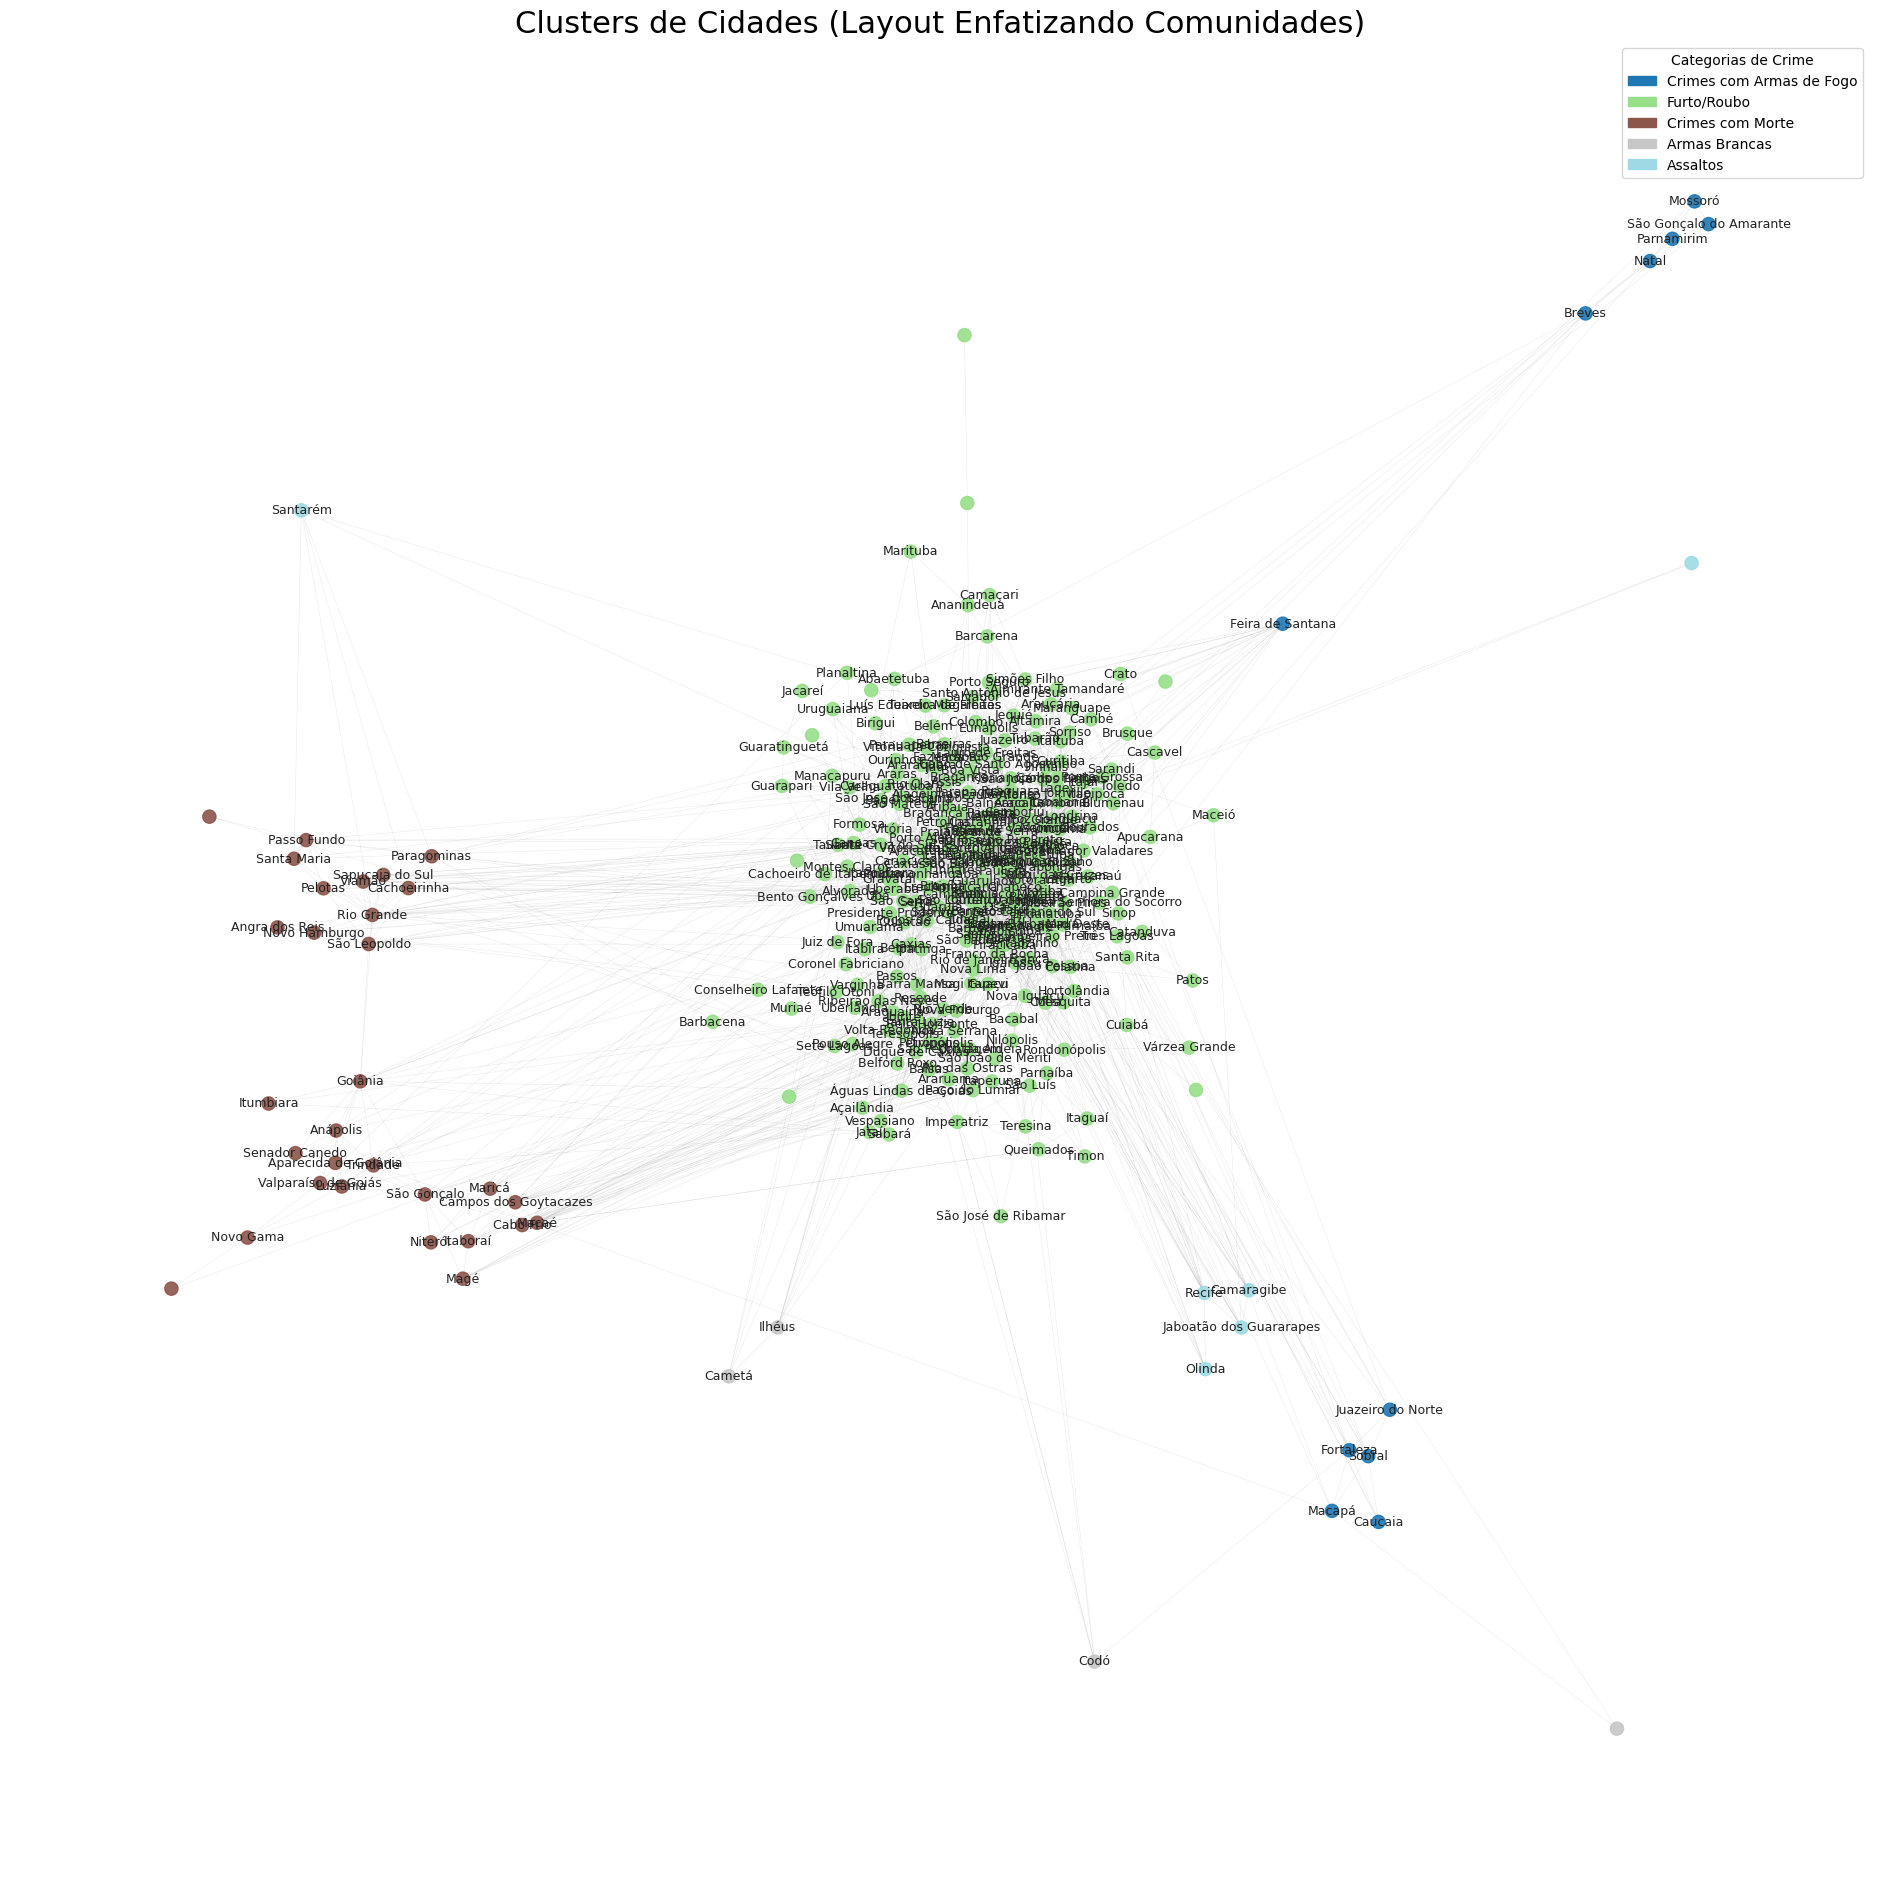

In [25]:
# crio lista de cores para cada nó baseado no rótulo final da propagação
node_colors_propagado = [map_cidade_id_categoria_final.get(node, -1) for node in G.nodes()]
cores_mapa = plt.cm.get_cmap('tab20', num_classes_crime)
# distribui a cor de categoria
node_colors_final = [cores_mapa(i) if i != -1 else 'lightgrey' for i in node_colors_propagado]
# preparo retângulos e nomes pra legenda das categorias
patches_legenda = [plt.Rectangle((0,0),1,1, color=cores_mapa(i)) for i in sorted(categorias_crime.keys())]
nomes_legenda = [categorias_crime[i] for i in sorted(categorias_crime.keys())]

# monto um grafo auxiliar pra dar pesos diferentes a arestas intra- vs inter-cluster
G_layout = nx.Graph()
G_layout.add_nodes_from(G.nodes())
peso_intra_cluster = 10.0   # força para manter juntos nós da mesma categoria
peso_inter_cluster = 0.1    # força menor para separar clusters

# atribuo peso alto se aresta for intra-cluster, baixo caso contrário
for u, v in G.edges():
    label_u = map_cidade_id_categoria_final.get(u, -1)
    label_v = map_cidade_id_categoria_final.get(v, -1)
    if label_u != -1 and label_v != -1:
        if label_u == label_v:
            G_layout.add_edge(u, v, weight=peso_intra_cluster)
        else:
            G_layout.add_edge(u, v, weight=peso_inter_cluster)
    else:
        # se algum nó não tiver rótulo, peso ainda menor
        G_layout.add_edge(u, v, weight=peso_inter_cluster * 0.5)

# uso spring_layout ponderado para agrupar clusters visualmente
pos_comunidade = nx.spring_layout(G_layout, weight='weight', seed=42, k=0.1, iterations=70)
print("Layout calculado.")

plt.figure(figsize=(24, 24))
nx.draw_networkx_nodes(G, pos_comunidade, node_size=90, node_color=node_colors_final, alpha=0.9)
nx.draw_networkx_edges(G, pos_comunidade, alpha=0.15, width=0.4, edge_color='gray')

# escolho quais rótulos exibir: grau ≥ 1% dos nós ou, se nenhum, os top 20
degree_threshold = max(3, int(G.number_of_nodes() * 0.01))
labels_to_draw = {node for node, degree in G.degree() if degree >= degree_threshold}
if not labels_to_draw and G.number_of_nodes() > 0:
    top_degree_nodes = sorted(G.degree, key=lambda item: item[1], reverse=True)[:20]
    labels_to_draw = {node[0] for node in top_degree_nodes}

# exibo os rótulos selecionados
labels = {node: node for node in labels_to_draw}
nx.draw_networkx_labels(G, pos_comunidade, labels=labels, font_size=9, font_color='#222222')

plt.title("Clusters de Cidades (Layout Enfatizando Comunidades)", fontsize=22)
plt.axis('off')
if patches_legenda:
    plt.legend(patches_legenda, nomes_legenda, title="Categorias de Crime", loc="upper right")
plt.show()

Listo as principais descrições de crimes agrupadas por cluster, mostrando as cidades e ocorrências pertencentes a cada categoria.


In [26]:
print("\n\n--- Detalhamento dos Crimes por Cluster/Categoria ---")

# para cada categoria final, mostro nome e detalhes
for cat_id_loop in sorted(cidades_por_categoria_final.keys()):
    nome_categoria = categorias_crime.get(cat_id_loop, f"ID Desconhecido {cat_id_loop}")
    print(f"\n\n==================== CLUSTER: {nome_categoria.upper()} ====================")

    # pego a lista de cidades que ficaram nesse cluster
    cidades_nesta_categoria = sorted(cidades_por_categoria_final.get(cat_id_loop, []))

    if not cidades_nesta_categoria:
        print("\nERRO: nenhuma city.")
        continue  # pula pra próxima categoria

    # junto todas as descrições originais dessas cidades para mostrar exemplos
    descricoes_totais_do_cluster = []
    for cidade_nome in cidades_nesta_categoria:
        descricoes_totais_do_cluster.extend(descricoes_por_cidade.get(cidade_nome, []))

    if not descricoes_totais_do_cluster:
        print("\nERRO: nenhuma city.")
    else:
        # mostro quais cidades fazem parte do cluster
        print(f"\n  Cidades neste cluster: {', '.join(cidades_nesta_categoria)}\n")
        print("  Crimes:")
        # listo cada ocorrência com numeração para facilitar a leitura
        for i, desc in enumerate(descricoes_totais_do_cluster, 1):
            print(f"    {i}. {desc}")



--- Detalhamento dos Crimes por Cluster/Categoria ---


==================== CLUSTER: CRIMES COM ARMAS DE FOGO ====================

  Cidades neste cluster: Breves, Caucaia, Feira de Santana, Fortaleza, Juazeiro do Norte, Macapá, Mossoró, Natal, Parnamirim, Sobral, São Gonçalo do Amarante

  Crimes:
    1. Vídeos registram tiroteio entre 'piratas' e polícia no Marajó - G1
    2. Membro de Facção é morto em confronto com a PM de Breves - DOL
    3. Marinheiro relata ataque de ‘piratas’ na Amazônia: ‘Chegaram atirando’ - Estadão
    4. Bebê desaparece em rio após colisão de barcos no Marajó (PA) - CNN Brasil
    5. Criminosos assaltam, ateiam fogo em 2 ônibus e atiram de fuzil contra viatura da GCM de SP - SBT News
    6. Crítica | ‘Lift: Roubo nas Alturas’ é um filme de assalto que traz mais do mesmo - CinePOP
    7. Empresas usam tecnologia para combater ‘piratas’ no Amazonas - amazonas atual
    8. Murilo Benício vive cenas de ação no Calçadão de Londrina em 'Assalto à Brasileira' 

## **Interpretações dos resultados:**

  Apesar da visualização no grafo dos clusters ser satisfatória (e de fato é),
fica evidente, ao exibir os clusters e os registros de crimes associados a eles por texto, que ainda há muito o que ser melhorado. Eu atribuo essa imprecisão a diversos fatores, como não ter tratado os dados da melhor maneira possível (já que minha remoção de ruído foi muito manual, o que significou em não remover tudo que podia). Além disso, é possível que mesmo ao tomar o cuidado de fazer o grafo a partir da ligação de cidades com similaridades entre crimes específicos, eu tenha perdido uma boa parte da granulosidade dos dados, o que também acontece quando eu limito meu limiar a 0.85 para garantir que o grafo terá somente uma componente.
Outro fator que justifica esse ocorrido é a falta de mais verificações prioritárias na propagação dos labels, algo que só pensei quando estava fazendo a matriz de riscos, ainda sim, o método semi-supervisionado claramente apresenta suas restrições e dificuldades. Mesmo mapeando 5 clusters manualmente e atribuindo diversas palavras chaves, é sempre possível encontrar crimes que não se enquadram em nenhum deles e que não são propriamente atribuídos a outros.

Eu já esperava que isso fosse ocorrer, o grafo é muito denso, acredito que sem especificar muito bem essas 5 seeds, eu não teria mais do que um cluster final. Porém, ainda que não tenha ficado tão bom quanto idealmente poderia, eu estou muito satisfeito com o que consegui fazer, as notícias dentro de um cluster claramente apresentam maior frequência de palavras que eu utilizei para classifica-los, o que mostra um nível satisfatório de sucesso considerando o ainda tão alto nível de ruído e de descrições que distoam tanto das demais.



# **Analises Extras:**

Nesse trecho eu traduzo cada descrição de crime em um score de impacto e combino isso com a probabilidade estacionária para criar a matriz de risco:

1.	Classificação das descrições

Defini a função classificar_descricao que percorre as categorias do mais grave (morte) para o menos grave (roubo). Assim, se um texto mencionar “morte” e “roubo”, ele já cai em “Crimes com Morte”. Isso garante que cada ocorrência seja atribuída à categoria mais crítica presente.

2.	Mapeamento numérico de impacto

Montei um dicionário impacto_numerico_map onde cada categoria recebe um valor crescente (5 para morte, 4 para armas brancas ou fogo, etc.). Em seguida, para cada cidade:
-	Peguei todas as descrições desse município.
-	Converti cada uma em seu valor de impacto.
-	Tirei a média desses valores, resultando num impacto médio por cidade.

3.	Discretização do impacto

Usei pd.cut para transformar esse impacto médio em 4 faixas:

-	1. Baixo Impacto (0–1.5)
-	2. Médio Impacto (1.5–2)
-	3. Alto Impacto (2–3)
-	4. Crítico (3–4)

4.	Categorias de probabilidade (frequencia)

Com pd.qcut, dividi a probabilidade estacionária de raro a quase certo.

5.	Construção da matriz de risco

Montei um DataFrame risk_score_matrix cujas linhas são as categorias de probabilidade (invertidas para ficar de cima pra baixo) e colunas as faixas de impacto. Cada célula recebe o produto

risco = (índice da probabilidade + 1) × (índice do impacto + 1)

Isso cria um score crescente: quanto maior probabilidade e maior impacto, maior o valor de risco.

6.	Anotação das ocorrências reais

Com um pivot_table, somei o número de ocorrências em cada combinação de probabilidade × impacto, resultando em risk_matrix_occurrences. Esses valores são usados como anotações no heatmap, mostrando o volume de casos em cada nível de risco.


O resultado é uma Matriz de Risco que une teoria (probabilidade × impacto) e prática (volume de ocorrências) em um único gráfico, facilitando a identificação dos quadrantes mais críticos que merecem atenção prioritária.

**OBS:**

Inicialmente eu fiz isso utilizando somente as probabilidades e o conjunto do df_mod, porém ele acabava por não cobrir todo o universo de crimes e nem representava o risco correto, já que o volume de ocorrências era significativamente composto por crimes menos graves, e desse problema que surgiu a necessidade de fazer uma análise ponderada dos crimes (a partir dos clusters conhecidos) de modo a realmente julgar o quão perigosa é uma região, não na sua média simples, mas sim considerando o quão críticos, em geral, são os crimes que ocorrem lá.

Ainda dá para melhorar muito, essa construção da matriz de risco foi simplesmente um jeito que encontrei de aplicar um tópico que eu estava estudando por fora e ver se eu conseguia fazer algo minimamente relevante.

/var/folders/bb/t3hfl2hd1gv6yy5d02vv55xr0000gn/T/ipykernel_5138/1332930300.py:56: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_matrix_occurrences = pd.pivot_table(


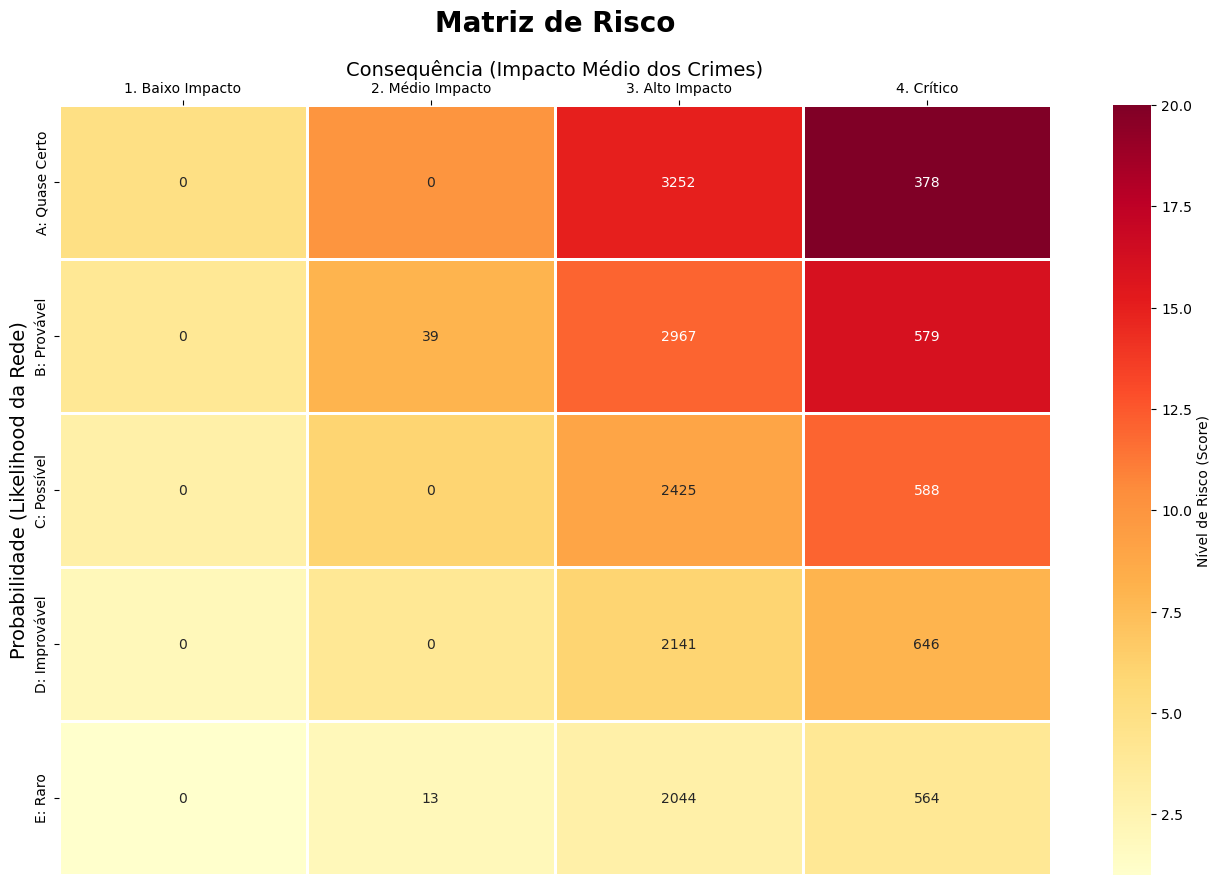

In [27]:
def classificar_descricao(descricao):
    # eu percorro as categorias em ordem reversa para garantir que, se um texto mencionar
    # tanto "morte" quanto "roubo", ele seja classificado como "Crimes com Morte"
    for cat_id in sorted(palavras_chave_categorias.keys(), reverse=True):
        for palavra in palavras_chave_categorias[cat_id]:
            if isinstance(descricao, str) and palavra in descricao.lower():
                return categorias_crime[cat_id]
    # se nenhuma palavra-chave bater, marco como não classificado
    return "Outros" # nunca aparece, mas deixei aqui na esperança de que algum dia apareça

# defino um valor numérico crescente de impacto para cada categoria
impacto_numerico_map = {
    "Crimes com Morte": 5, "Armas Brancas": 4, "Crimes com Armas de Fogo": 4,
    "Assaltos": 3, "Furto/Roubo": 2, "Outros / Não Classificado": 1
}

# calculo para cada cidade um score médio de impacto, somando os impactos das descrições
impactos_ponderados = {}
for cidade in df_comparativo['Cidade']:
    descricoes_cidade = descricoes_por_cidade.get(cidade, [])
    if not descricoes_cidade: continue
    scores_individuais = [impacto_numerico_map.get(classificar_descricao(desc), 1) for desc in descricoes_cidade]
    impactos_ponderados[cidade] = sum(scores_individuais) / len(scores_individuais)

# adiciono essa média ao DataFrame e removo quem ficou sem valor
df_comparativo['Impacto_Ponderado'] = df_comparativo['Cidade'].map(impactos_ponderados)
df_comparativo = df_comparativo.dropna(subset=['Impacto_Ponderado'])

# crio faixas de impacto que fazem sentido pro meu conjunto de dados
bins_impacto = [0, 1.5, 2, 3, 4]
labels_impacto = ['1. Baixo Impacto', '2. Médio Impacto', '3. Alto Impacto', '4. Crítico']
df_comparativo['Impacto_Ponderado_Label'] = pd.cut(
    df_comparativo['Impacto_Ponderado'],
    bins=bins_impacto,
    labels=labels_impacto,
    right=False
)

# converto a probabilidade estimada em 5 categorias de likelihood usando quantis
likelihood_labels = ['E: Raro', 'D: Improvável', 'C: Possível', 'B: Provável', 'A: Quase Certo']
df_comparativo['Likelihood_Label'] = pd.qcut(
    df_comparativo['Probabilidade_Estacionaria'],
    q=5,
    labels=likelihood_labels,
    duplicates='drop'
)

# monto a matriz de score de risco combinando impacto e probabilidade
risk_score_matrix = pd.DataFrame(index=likelihood_labels[::-1], columns=labels_impacto)
for i, ll in enumerate(likelihood_labels):
    for j, il in enumerate(labels_impacto):
        # risco = nível de probabilidade × nível de impacto
        risk_score_matrix.at[ll, il] = (i + 1) * (j + 1)

# também monto uma tabela de quantas ocorrências há em cada combinação
risk_matrix_occurrences = pd.pivot_table(
    df_comparativo.dropna(subset=['Impacto_Ponderado_Label']),
    values='Numero_Ocorrencias',
    index='Likelihood_Label',
    columns='Impacto_Ponderado_Label',
    aggfunc='sum',
    fill_value=0
).reindex(index=likelihood_labels[::-1], columns=labels_impacto, fill_value=0)

plt.figure(figsize=(16, 10))
ax = sns.heatmap(
    risk_score_matrix.astype(float),
    annot=risk_matrix_occurrences,
    fmt='d',
    cmap='YlOrRd',
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Nível de Risco (Score)'}
)
ax.set_title('Matriz de Risco', fontsize=20, weight='bold', pad=20)
ax.set_xlabel('Consequência (Impacto Médio dos Crimes)', fontsize=14)
ax.set_ylabel('Probabilidade (Likelihood da Rede)', fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.show()

### **Painel Interativo de Risco por Município**

Nesta célula, eu criei um menu interativo para explorar o resultado do modelo de risco cidade a cidade:

1.	Seleção da Cidade
-	O usuário escolhe o município de interesse e a função analisar_cidade_final é chamada.

2.	Replotagem do Heatmap

-	Dentro da função, redesenho a Matriz de Risco (o mesmo heatmap de antes) e destaco a combinação correspondente de probabilidade × impacto daquela cidade.
-	Assim fica muito claro onde cada município se encaixa no risco geral.

Isso permite analisar de forma dinâmica e imediata o perfil de risco de qualquer cidade, sem precisar refazer todo o cálculo ou caçar manualmente as coordenadas na matriz.

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.patches as patches

# preparo a lista de cidades válidas para o painel
df_final_analise = df_comparativo.dropna(subset=['Impacto_Ponderado_Label', 'Likelihood_Label'])
lista_cidades_final = sorted(df_final_analise['Cidade'].unique())

def analisar_cidade_final(cidade_selecionada):
    # pescando os dados de risco daquela cidade no DataFrame final
    info_cidade = df_final_analise[df_final_analise['Cidade'] == cidade_selecionada].iloc[0]

    # redesenho a matriz de risco e destaco a célula correspondente à cidade
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(
        risk_score_matrix.astype(float),
        annot=risk_matrix_occurrences,
        fmt='d',
        cmap='YlOrRd',
        linewidths=1,
        linecolor='white',
        cbar_kws={'label': 'Nível de Risco (Score)'},
        ax=ax
    )

    # encontro as coordenadas da célula que representa a cidade na matriz
    y_pos = risk_score_matrix.index.get_loc(info_cidade['Likelihood_Label'])
    x_pos = risk_score_matrix.columns.get_loc(info_cidade['Impacto_Ponderado_Label'])
    # desenho um retângulo azul ao redor da célula de risco da cidade
    ax.add_patch(patches.Rectangle((x_pos, y_pos), 1, 1, fill=False, edgecolor='blue', lw=4, clip_on=False))

    # título e rótulos para indicar claramente o painel da cidade
    ax.set_title(f'Posição de {cidade_selecionada} na Matriz de Risco', fontsize=20, weight='bold', pad=20)
    ax.set_xlabel('Consequência (Impacto Médio dos Crimes)', fontsize=14)
    ax.set_ylabel('Probabilidade (Likelihood da Rede)', fontsize=14)
    ax.xaxis.set_ticks_position('top'); ax.xaxis.set_label_position('top')
    plt.show()

    # resumo textual logo abaixo do gráfico
    print("=======================================================")
    print(f"PAINEL DE RISCO PARA: {cidade_selecionada.upper()}")
    print("=======================================================")
    print(f"  -> Nível de Probabilidade (Likelihood): {info_cidade['Likelihood_Label']}")
    print(f"  -> Nível de Impacto (Ponderado):        {info_cidade['Impacto_Ponderado_Label']}")
    print("-------------------------------------------------------")
    print(f"  -> Score de Impacto Médio (1-5):        {info_cidade['Impacto_Ponderado']:.2f}")
    print(f"  -> Score de Probabilidade (Markov):     {info_cidade['Probabilidade_Estacionaria']:.4f}")
    print(f"  -> Total de Ocorrências Registradas:    {int(info_cidade['Numero_Ocorrencias'])}")
    print("=======================================================")

# crio o widget de seleção de cidade e conecto à função de análise
widgets.interact(analisar_cidade_final, cidade_selecionada=lista_cidades_final);

interactive(children=(Dropdown(description='cidade_selecionada', options=('Abaetetuba', 'Alagoinhas', 'Almiran…